In [6]:
!pip install datasets transformers
!pip install fvcore
!pip install -U zetascale

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [7]:
import torch
import torch.nn.functional as F
from torch import Tensor, nn
import subprocess
import time
import matplotlib.pyplot as plt
from zeta.nn import *  # noqa: F403, E402
from fvcore.nn import FlopCountAnalysis, flop_count

from zeta.nn import FeedForward, MultiQueryAttention

avg_power = [0] * 3
avg_flops = [0] * 3
num_passes= 0

class SwitchGate(nn.Module):
    """
    SwitchGate module for MoE (Mixture of Experts) model.

    Args:
        dim (int): Input dimension.
        num_experts (int): Number of experts.
        capacity_factor (float, optional): Capacity factor for sparsity. Defaults to 1.0.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.
    """

    def __init__(
        self,
        dim,
        num_experts: int,
        capacity_factor: float = 1.0,
        epsilon: float = 1e-6,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.num_experts = num_experts
        self.capacity_factor = capacity_factor
        self.epsilon = epsilon
        self.w_gate = nn.Linear(dim, num_experts)

    def forward(self, x: Tensor, use_aux_loss=False):
        """
        Forward pass of the SwitchGate module.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Gate scores.
        """
        # Compute gate scores
        gate_scores = F.softmax(self.w_gate(x), dim=-1)
        #print(gate_scores)

        # Determine the top-1 expert for each token
        capacity = int(self.capacity_factor * x.size(0))

        #top_k_scores, top_k_indices = gate_scores.topk(1, dim=-1)

        # # Mask to enforce sparsity
        # #mask = torch.zeros_like(gate_scores).scatter_(
        #     1, top_k_indices, 1
        # )

        # Combine gating scores with the mask
        # masked_gate_scores = gate_scores * mask

        # Denominators
        denominators = (
            gate_scores.sum(0, keepdim=True) + self.epsilon
        )

        # Norm gate scores to sum to the capacity
        gate_scores = (gate_scores / denominators) * capacity

        if use_aux_loss:
            load = gate_scores.sum(0)  # Sum over all examples
            importance = gate_scores.sum(1)  # Sum over all experts

            # Aux loss is mean suqared difference between load and importance
            loss = ((load - importance) ** 2).mean()

            return gate_scores, loss

        return gate_scores, None


class SwitchMoE(nn.Module):
    """
    A module that implements the Switched Mixture of Experts (MoE) architecture.

    Args:
        dim (int): The input dimension.
        hidden_dim (int): The hidden dimension of the feedforward network.
        output_dim (int): The output dimension.
        num_experts (int): The number of experts in the MoE.
        capacity_factor (float, optional): The capacity factor that controls the capacity of the MoE. Defaults to 1.0.
        mult (int, optional): The multiplier for the hidden dimension of the feedforward network. Defaults to 4.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Attributes:
        dim (int): The input dimension.
        hidden_dim (int): The hidden dimension of the feedforward network.
        output_dim (int): The output dimension.
        num_experts (int): The number of experts in the MoE.
        capacity_factor (float): The capacity factor that controls the capacity of the MoE.
        mult (int): The multiplier for the hidden dimension of the feedforward network.
        experts (nn.ModuleList): The list of feedforward networks representing the experts.
        gate (SwitchGate): The switch gate module.


    """
    def get_gpu_power(self):
        # Use nvidia-smi to get the current power draw (in watts)
        try:
            power_info = subprocess.check_output(['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'])
            power_draw = float(power_info.strip())  # Power in watts (W)
            return power_draw
        except Exception as e:
            print("Error getting GPU power:", e)
            return 0

    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        output_dim: int,
        num_experts: int,
        capacity_factor: float = 1.0,
        mult: int = 4,
        use_aux_loss: bool = False,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_experts = num_experts
        self.capacity_factor = capacity_factor
        self.mult = mult
        self.use_aux_loss = use_aux_loss
        self.start_time = None
        self.end_time = None
        self.experts = nn.ModuleList(
            [
                FeedForward(dim, dim, mult, *args, **kwargs)
                for _ in range(num_experts)
            ]
        )

        self.gate = SwitchGate(
            dim,
            num_experts,
            capacity_factor,
        )

        self.flops_tracker = torch.zeros(num_experts, dtype=torch.float32)
        self.total_batches = 0
        self.flops_for_batch = {i: 0 for i in range(self.num_experts)}  # FLOPs for the current batch
        self.energy_per_flop = 1e-12

        #self.power_tracker = [0.0] * num_experts

        self.power_tracker = torch.zeros(num_experts, dtype=torch.float32)
        self.flops_per_expert = []
        self.energy_per_expert = []


    def plot_flops_vs_energy(self,total_energy):
      num_experts = len(self.flops_tracker)

    # Compute average FLOPs and energy for each expert
      average_flops_per_expert = self.flops_tracker / self.total_batches


    # Create the plot
      plt.figure(figsize=(10, 6))

    # Plot each expert's FLOPs vs Energy individually
      for i in range(num_experts):
        plt.plot(average_flops_per_expert[i].cpu().numpy(),
                 total_energy[i].cpu().numpy(),
                 'o-', label=f"Expert {i}")

    # Add labels and title
      plt.xlabel("FLOPs (gFLOPs)")
      plt.ylabel("Energy Expenditure (Joules)")
      plt.title("FLOPs vs Energy Expenditure for Each Expert")
      plt.grid(True)
      plt.legend()
      plt.show()

    def forward(self, x: Tensor,energy_data=None):
      gate_scores, loss = self.gate(x)

      initial_power = self.get_gpu_power()


      batch_size, seq_len, num_experts = gate_scores.size()

    # Get the top expert index for each token
      top_k_scores, top_k_indices = gate_scores.topk(1, dim=-1)  # top_k_indices is of shape (batch_size, seq_len, 1)

    # Flatten for easier manipulation
      x_flat = x.view(-1, x.size(-1))  # Flatten to (batch_size * seq_len, dim)
      top_k_indices_flat = top_k_indices.view(-1)  # Flatten to (batch_size * seq_len,)

    # Prepare outputs storage
      selected_expert_outputs = torch.zeros(batch_size * seq_len, x.size(-1), device=x.device)
      expert_weights = torch.zeros(batch_size * seq_len, device=x.device)
      #selected_expert_outputs = torch.zeros_like(x_flat)

      total_flops = torch.zeros(num_experts, device=x.device)
      total_energy = torch.zeros(num_experts, device=x.device)

      total_flops = 0


    # Process each expert independently

      for i in range(num_experts):
        # Get tokens assigned to this expert
        expert_mask = (top_k_indices_flat == i).nonzero(as_tuple=True)[0]
        #expert_mask = torch.arange(x_flat.size(0), device=x.device) #uncomment this line and comment out the above to use K>1

        if expert_mask.numel() > 0:
            tokens_for_expert = x_flat[expert_mask]
            # Compute expert output for these tokens
            self.start_time = time.time()
            expert_output = self.experts[i](tokens_for_expert)
            final_power = self.get_gpu_power()
            self.end_time = time.time()

            total_time= self.end_time - self.start_time

            flops,_ = flop_count(self.experts[i],(tokens_for_expert,))
            expert_flops = sum(flops.values())
            self.flops_tracker[i] += expert_flops

            total_energy[i] += final_power * total_time  # Energy in joules


            # Store the expert output in the corresponding positions
            #selected_expert_outputs.index_add_(0, expert_mask, expert_output)
            weights = top_k_scores.view(-1)[expert_mask]
            expert_weights[expert_mask] = weights.squeeze()

            # Store the expert output in the corresponding positions
            selected_expert_outputs.index_add_(0, expert_mask, expert_output * weights.unsqueeze(1))


    # Reshape the selected expert outputs back to (batch_size, seq_len, dim)
      moe_output = selected_expert_outputs.view(batch_size, seq_len, -1)
      self.total_batches += 1

      average_flops_per_expert = self.flops_tracker / self.total_batches
      avg_energy = total_energy / self.total_batches

      total_energy = total_energy / self.total_batches

      flops_per_layer = 0


      for i in range(num_experts):
         print(f"  Expert {i}: {avg_energy[i]:.4f} J")
         print(f"  Expert {i}: {average_flops_per_expert[i]:.4f} gFlops")
         flops_per_layer += average_flops_per_expert[i]
      self.plot_flops_vs_energy(avg_energy)

      return moe_output, loss,flops_per_layer

#moe_output = torch.stack(expert_outputs, dim=0).sum(dim=0)
class SwitchTransformerBlock(nn.Module):
    """
    SwitchTransformerBlock is a module that represents a single block of the Switch Transformer model.

    Args:
        dim (int): The input dimension of the block.
        heads (int): The number of attention heads.
        dim_head (int): The dimension of each attention head.
        mult (int, optional): The multiplier for the hidden dimension in the feed-forward network. Defaults to 4.
        dropout (float, optional): The dropout rate. Defaults to 0.1.
        depth (int, optional): The number of layers in the block. Defaults to 12.
        num_experts (int, optional): The number of experts in the SwitchMoE layer. Defaults to 6.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Attributes:
        dim (int): The input dimension of the block.
        heads (int): The number of attention heads.
        dim_head (int): The dimension of each attention head.
        mult (int): The multiplier for the hidden dimension in the feed-forward network.
        dropout (float): The dropout rate.
        attn_layers (nn.ModuleList): List of MultiQueryAttention layers.
        ffn_layers (nn.ModuleList): List of SwitchMoE layers.

    Examples:
        >>> block = SwitchTransformerBlock(dim=512, heads=8, dim_head=64)
        >>> x = torch.randn(1, 10, 512)
        >>> out = block(x)
        >>> out.shape

    """

    def __init__(
        self,
        dim: int,
        heads: int,
        dim_head: int,
        mult: int = 4,
        dropout: float = 0.1,
        num_experts: int = 3,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.mult = mult
        self.dropout = dropout

        self.attn = MultiQueryAttention(
            dim, heads, qk_ln=True * args, **kwargs
        )

        self.ffn = SwitchMoE(
            dim, dim * mult, dim, num_experts, *args, **kwargs
        )

        self.add_norm = nn.LayerNorm(dim)

    def forward(self, x: Tensor):
        """
        Forward pass of the SwitchTransformerBlock.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output tensor.

        """
        resi = x
        x, _, _ = self.attn(x)
        attnflops,_ = flop_count(self.attn,(x,))
        x = x + resi
        x = self.add_norm(x)
        normflops,_ = flop_count(self.add_norm,(x,))
        add_normed = x

        ##### MoE #####
        x, _ ,ffn_flops= self.ffn(x)
        x = x + add_normed
        x = self.add_norm(x)
        total_flops = sum(attnflops.values()) + sum(normflops.values()) + ffn_flops.item()

        return x,total_flops

class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_len: int, embed_dim: int):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, embed_dim)

    def forward(self, x: Tensor):
        # x is expected to be of shape (batch_size, seq_len)
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        return self.position_embeddings(positions)


class SwitchTransformer(nn.Module):
    """
    SwitchTransformer is a PyTorch module that implements a transformer model with switchable experts.

    Args:
        num_tokens (int): The number of tokens in the input vocabulary.
        dim (int): The dimensionality of the token embeddings and hidden states.
        heads (int): The number of attention heads.
        dim_head (int, optional): The dimensionality of each attention head. Defaults to 64.
        mult (int, optional): The multiplier for the hidden dimension in the feed-forward network. Defaults to 4.
        dropout (float, optional): The dropout rate. Defaults to 0.1.
        num_experts (int, optional): The number of experts in the switchable experts mechanism. Defaults to 3.
        *args: Additional positional arguments.
        **kwargs: Additional keyword arguments.


    """

    def __init__(
        self,
        num_tokens: int,
        dim: int,
        heads: int,
        dim_head: int = 64,
        mult: int = 4,
        dropout: float = 0.1,
        num_experts: int = 3,
        depth: int = 4,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.num_tokens = num_tokens
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.mult = mult
        self.dropout = dropout
        self.num_experts = num_experts
        self.depth = depth
        self.sequence_length= 256

        self.embedding = nn.Embedding(num_tokens, dim)
        self.position_embeddings = nn.Embedding(self.sequence_length, dim)
        self.layers = nn.ModuleList([])
        self.start_time = None

        for _ in range(depth):
            self.layers.append(
                SwitchTransformerBlock(
                    dim,
                    heads,
                    dim_head,
                    mult,
                    dropout,
                    num_experts,
                    *args,
                    **kwargs,
                )
            )

        self.to_out = nn.Sequential(
            nn.Softmax(dim=-1),
            nn.LayerNorm(dim),
            nn.Linear(dim, num_tokens),
        )
    def get_gpu_power(self):
        # Use nvidia-smi to get the current power draw (in watts)
        try:

            power_info = subprocess.check_output(['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'])
            power_draw = float(power_info.strip())  # Power in watts (W)
            return power_draw
        except Exception as e:
            print("Error getting GPU power:", e)
            return 0

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the SwitchTransformer.

        Args:
            x (Tensor): The input tensor of shape (batch_size, sequence_length).

        Returns:
            Tensor: The output tensor of shape (batch_size, sequence_length, num_tokens).
        """
        # Embed tokens through embedding layer

        x = x.long()




        x = self.embedding(x)

        positions = torch.arange(self.sequence_length, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pEmbed= self.position_embeddings(positions)
        x = x + pEmbed

        flops=[]
        i=1

        initial_power = self.get_gpu_power()

        # Pass through the transformer block with MoE, it's in modulelist
        for layer in self.layers:
            print("Layer ",i)
            i+=1

            self.start_time = time.time()
            x,ffn_flops= layer(x)
            final_power = self.get_gpu_power()
            end_time = time.time()
            elapsed_time = end_time - self.start_time
            energy_in_joules = final_power * elapsed_time
            print("Layer", i , "Energy in joules: ", energy_in_joules)
            flops.append(ffn_flops)



        # Project to output tokens
        x = self.to_out(x)




        for i in range(len(flops)):
              flops_val = flops[i]
              print(f"Layer {i+1} Gflops: {flops_val}")

        return x,flops

In [8]:
!apt-get install git-lfs
!git lfs install
!GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/datasets/allenai/c4
%cd c4
!git lfs pull --include "en/c4-train.00000-of-01024.json.gz"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Updated git hooks.
Git LFS initialized.
Cloning into 'c4'...
remote: Enumerating objects: 87108, done.
remote: Total 87108 (delta 0), reused 0 (delta 0), pack-reused 87108 (from 1)
Receiving objects: 100% (87108/87108), 12.30 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (69221/69221), done.
/content/c4/c4


In [9]:
from datasets import load_dataset

from transformers import T5TokenizerFast, T5Tokenizer

import gzip
import json

def load_json_gz(filepath):
    with gzip.open(filepath, 'rb') as f:
        for line in f:
            yield json.loads(line)

# Load the small subset you downloaded
dataset_path = 'en/c4-train.00000-of-01024.json.gz'
data = list(load_json_gz(dataset_path))

# Preview a few examples
print(data[:2])

# Load the fast version of the T5 tokenizer
#tokenizer = T5TokenizerFast.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained('t5-small', use_fast=True)
# Load the C4 dataset
tokenized_data = [tokenizer.encode(d['text'], return_tensors='pt') for d in data[:100]]

#tokenized_data.set_format(type="torch", columns=["input_ids"])

[{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': '2019-04-25T12:57:54Z', 'url': 'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'}, {'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb internal drive and a 24

Token indices sequence length is longer than the specified maximum sequence length for this model (2600 > 512). Running this sequence through the model will result in indexing errors


100
NUM_TOKENS  32000
Layer  1
  Expert 0: 0.7240 J
  Expert 0: 2.2649 gFlops
  Expert 1: 0.6757 J
  Expert 1: 2.6277 gFlops
  Expert 2: 0.6735 J
  Expert 2: 3.6973 gFlops


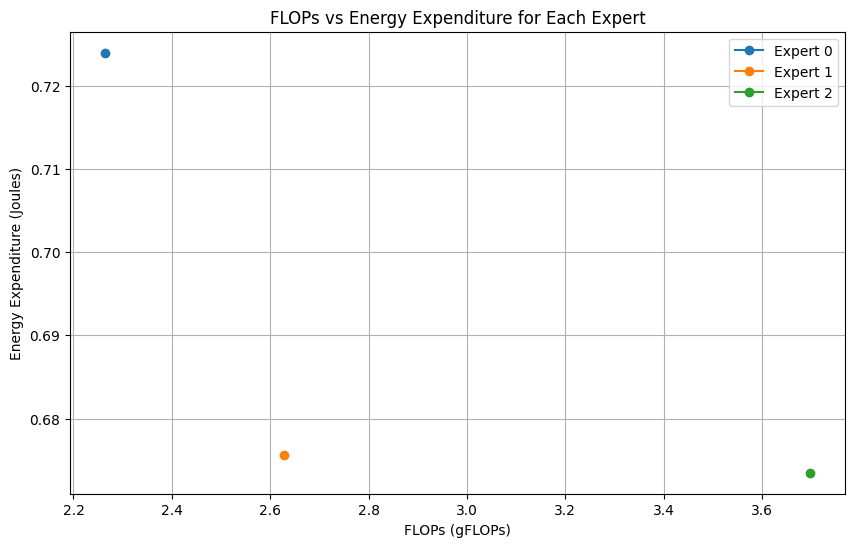

Layer 2 Energy in joules:  15.740493469238281
Layer  2
  Expert 0: 0.6579 J
  Expert 0: 2.3782 gFlops
  Expert 1: 0.7250 J
  Expert 1: 3.7581 gFlops
  Expert 2: 0.6573 J
  Expert 2: 2.4537 gFlops


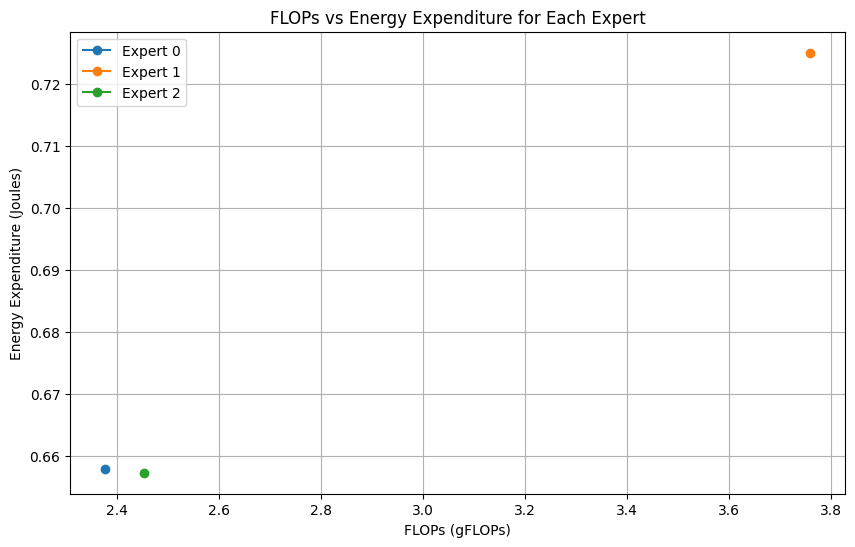

Layer 3 Energy in joules:  15.29298990726471
Layer  3
  Expert 0: 0.7253 J
  Expert 0: 2.7326 gFlops
  Expert 1: 0.7922 J
  Expert 1: 2.6110 gFlops
  Expert 2: 0.6992 J
  Expert 2: 3.2464 gFlops


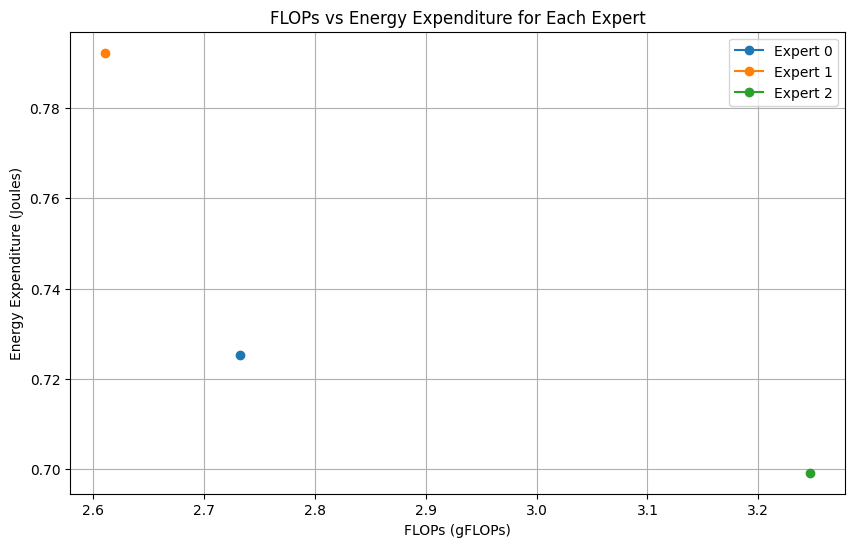

Layer 4 Energy in joules:  13.673642292022706
Layer  4
  Expert 0: 0.7066 J
  Expert 0: 2.8542 gFlops
  Expert 1: 0.8113 J
  Expert 1: 2.4998 gFlops
  Expert 2: 0.6562 J
  Expert 2: 3.2359 gFlops


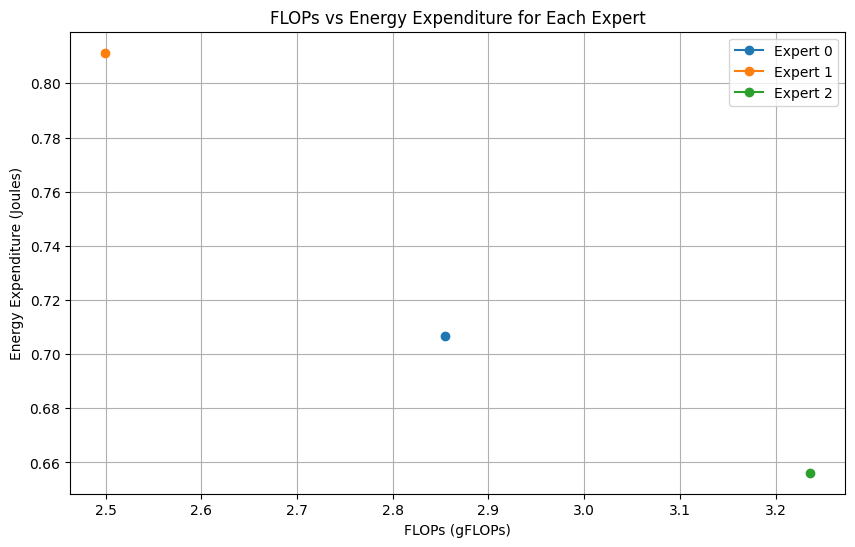

Layer 5 Energy in joules:  14.237224693298339
Layer  5
  Expert 0: 0.7472 J
  Expert 0: 3.0262 gFlops
  Expert 1: 0.7042 J
  Expert 1: 2.8605 gFlops
  Expert 2: 0.7702 J
  Expert 2: 2.7032 gFlops


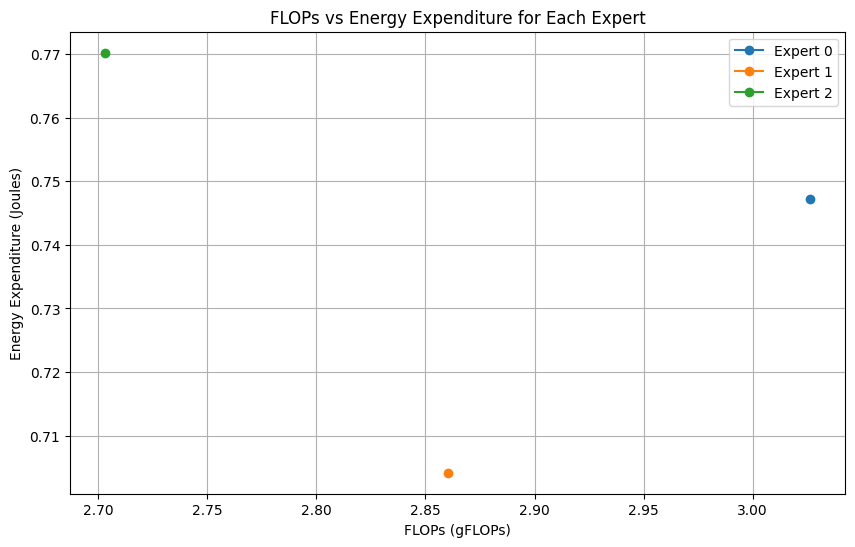

Layer 6 Energy in joules:  14.245755343437196
Layer  6
  Expert 0: 0.6432 J
  Expert 0: 2.8668 gFlops
  Expert 1: 0.7327 J
  Expert 1: 2.7557 gFlops
  Expert 2: 0.7267 J
  Expert 2: 2.9675 gFlops


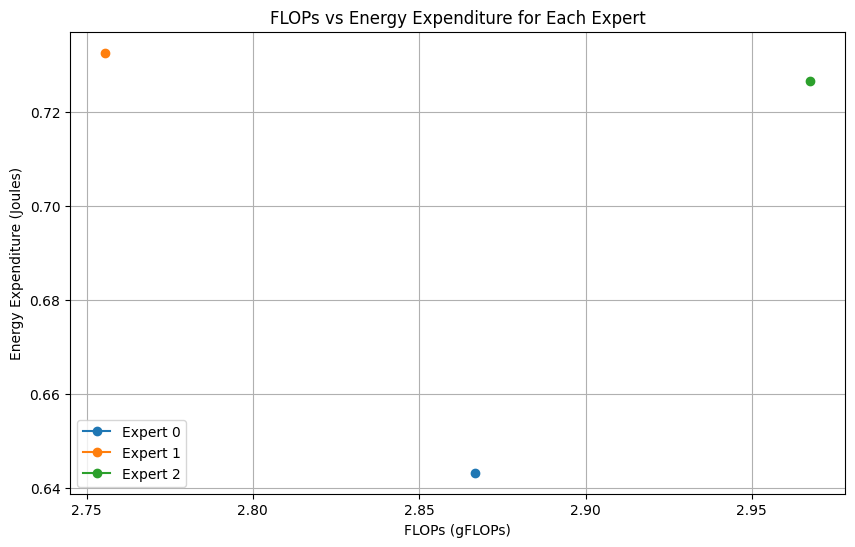

Layer 7 Energy in joules:  13.758317399024964
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.5063 J
  Expert 0: 2.3635 gFlops
  Expert 1: 0.3907 J
  Expert 1: 2.7179 gFlops
  Expert 2: 0.3950 J
  Expert 2: 3.5085 gFlops


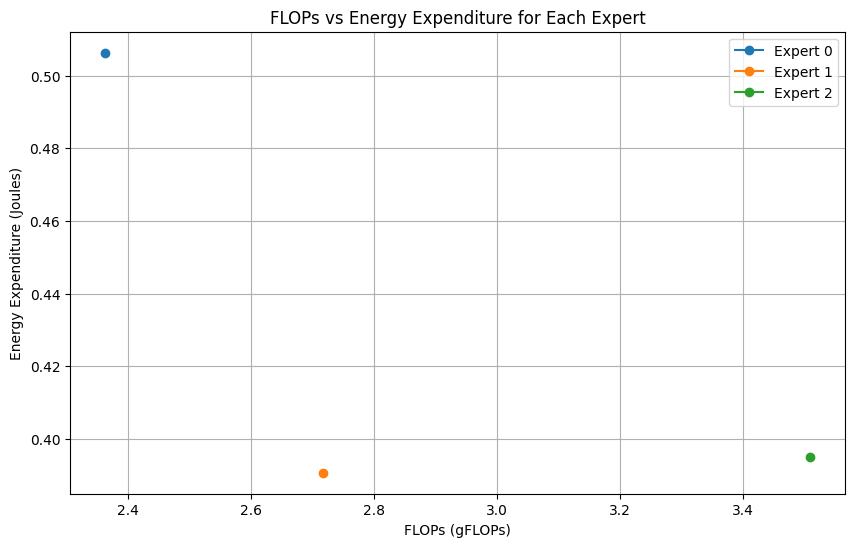

Layer 2 Energy in joules:  21.267152364254
Layer  2
  Expert 0: 0.4536 J
  Expert 0: 2.4411 gFlops
  Expert 1: 0.4899 J
  Expert 1: 3.5589 gFlops
  Expert 2: 0.4955 J
  Expert 2: 2.5900 gFlops


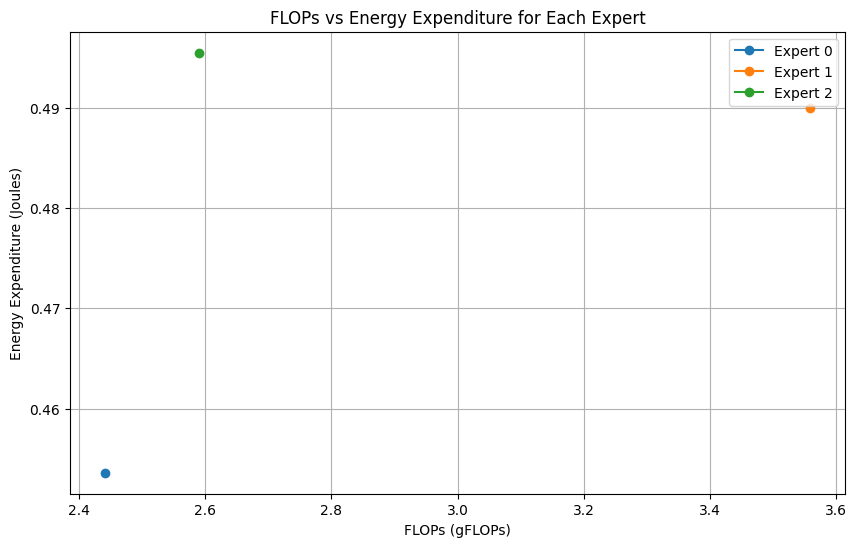

Layer 3 Energy in joules:  17.824846172332766
Layer  3
  Expert 0: 0.4353 J
  Expert 0: 2.8500 gFlops
  Expert 1: 0.5929 J
  Expert 1: 2.5365 gFlops
  Expert 2: 0.5033 J
  Expert 2: 3.2034 gFlops


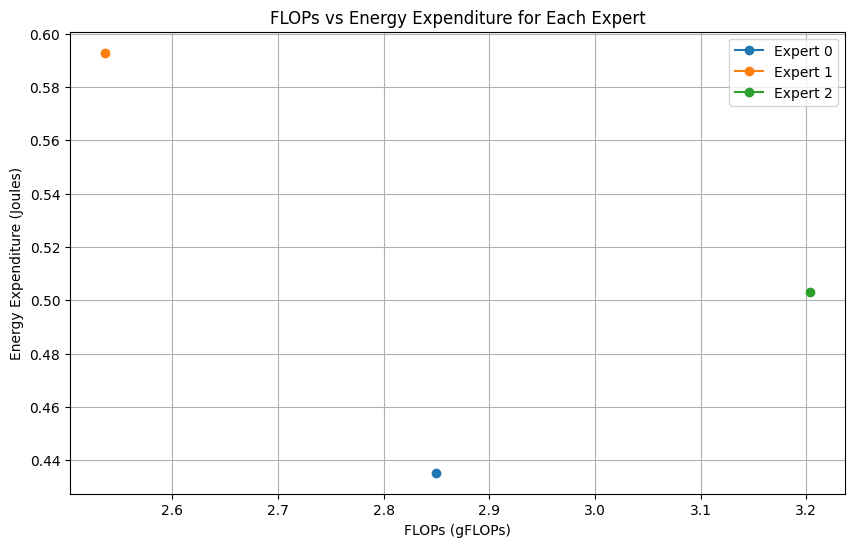

Layer 4 Energy in joules:  19.188430140018465
Layer  4
  Expert 0: 0.4715 J
  Expert 0: 2.9329 gFlops
  Expert 1: 0.5401 J
  Expert 1: 2.6781 gFlops
  Expert 2: 0.5382 J
  Expert 2: 2.9790 gFlops


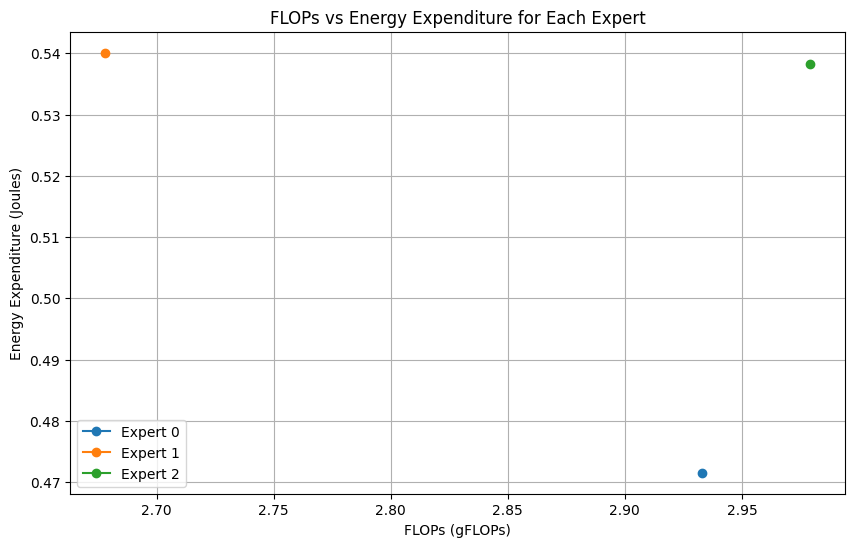

Layer 5 Energy in joules:  14.590512857437133
Layer  5
  Expert 0: 0.3203 J
  Expert 0: 2.8658 gFlops
  Expert 1: 0.3248 J
  Expert 1: 3.0136 gFlops
  Expert 2: 0.3149 J
  Expert 2: 2.7106 gFlops


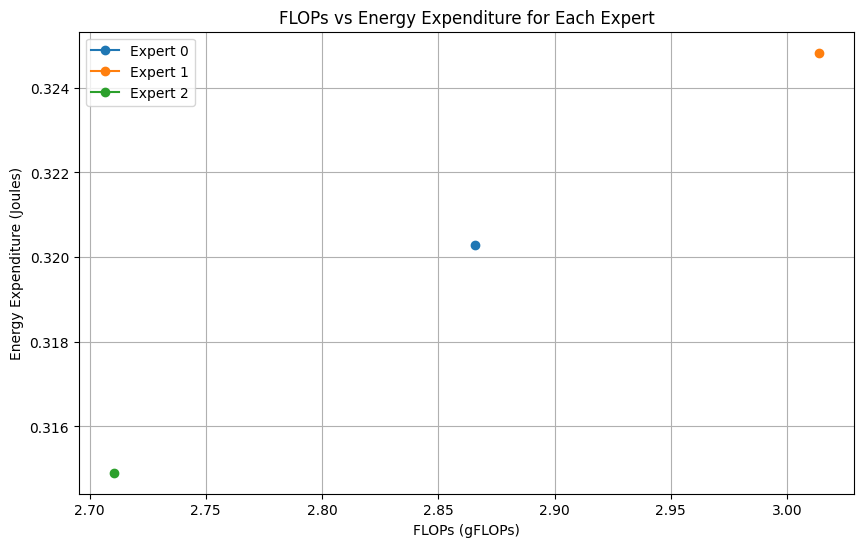

Layer 6 Energy in joules:  13.474169626235962
Layer  6
  Expert 0: 0.3180 J
  Expert 0: 2.8521 gFlops
  Expert 1: 0.3819 J
  Expert 1: 2.7651 gFlops
  Expert 2: 0.4511 J
  Expert 2: 2.9727 gFlops


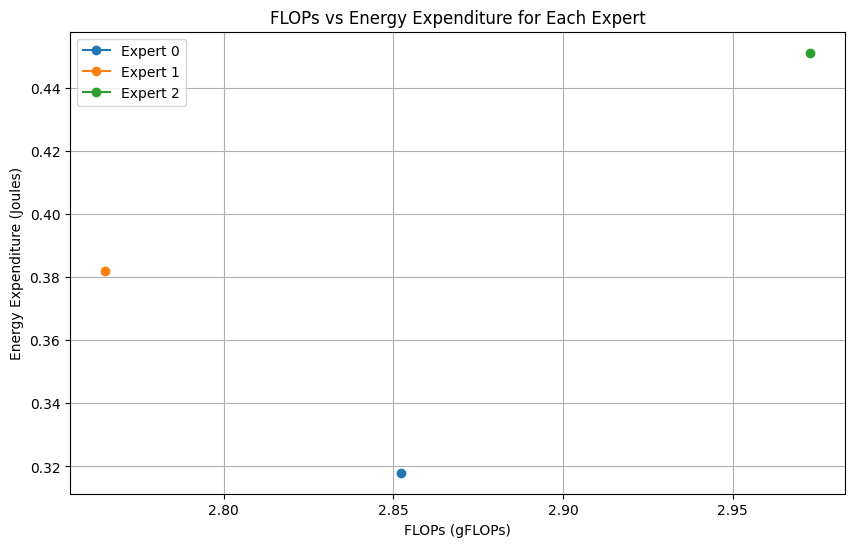

Layer 7 Energy in joules:  13.86083785533905
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.2629 J
  Expert 0: 2.3942 gFlops
  Expert 1: 0.2537 J
  Expert 1: 2.7200 gFlops
  Expert 2: 0.2993 J
  Expert 2: 3.4757 gFlops


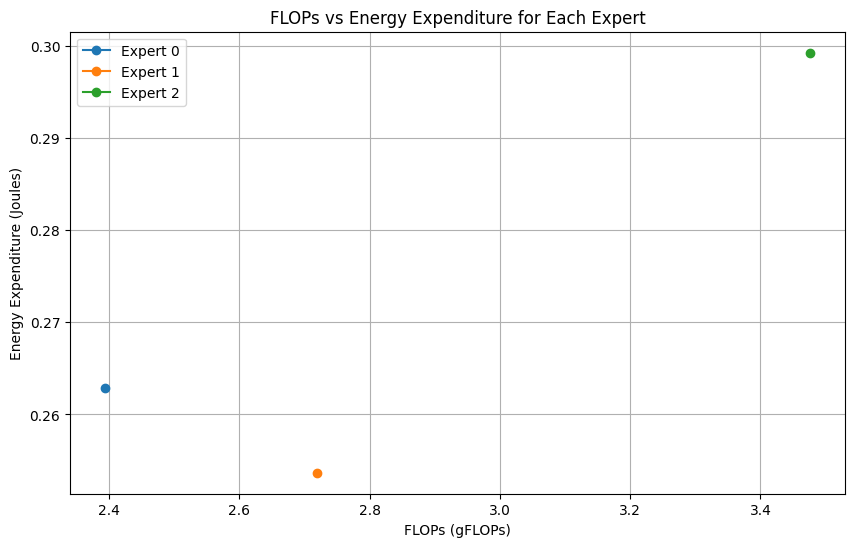

Layer 2 Energy in joules:  25.231773247718813
Layer  2
  Expert 0: 0.3766 J
  Expert 0: 2.4739 gFlops
  Expert 1: 0.3302 J
  Expert 1: 3.4967 gFlops
  Expert 2: 0.3202 J
  Expert 2: 2.6193 gFlops


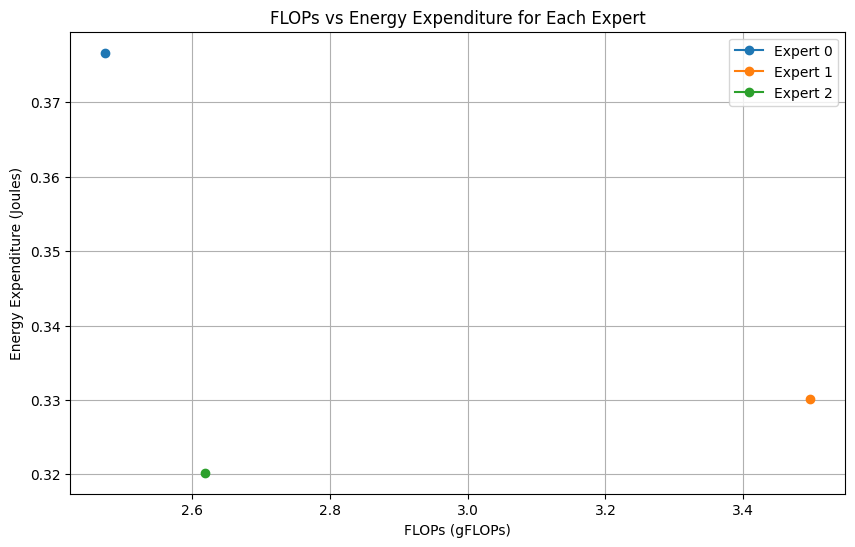

Layer 3 Energy in joules:  25.349806029796603
Layer  3
  Expert 0: 0.4171 J
  Expert 0: 2.9570 gFlops
  Expert 1: 0.4328 J
  Expert 1: 2.3810 gFlops
  Expert 2: 0.5046 J
  Expert 2: 3.2520 gFlops


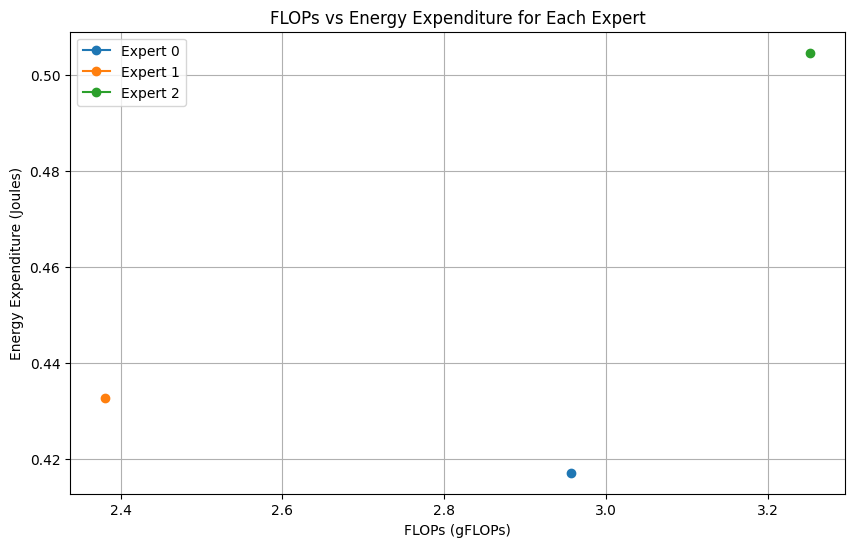

Layer 4 Energy in joules:  23.666680994033815
Layer  4
  Expert 0: 0.3006 J
  Expert 0: 2.9381 gFlops
  Expert 1: 0.2856 J
  Expert 1: 2.8514 gFlops
  Expert 2: 0.2578 J
  Expert 2: 2.8004 gFlops


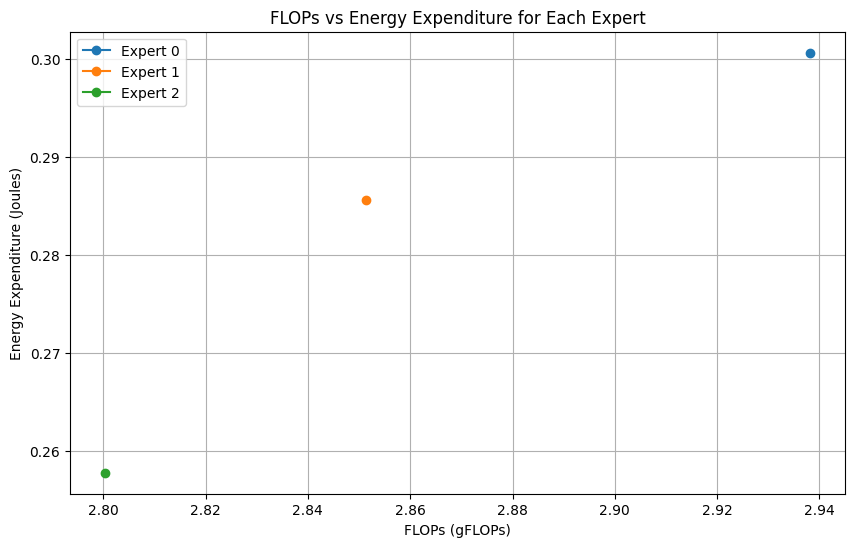

Layer 5 Energy in joules:  20.870643396377563
Layer  5
  Expert 0: 0.2547 J
  Expert 0: 2.7445 gFlops
  Expert 1: 0.2930 J
  Expert 1: 3.1485 gFlops
  Expert 2: 0.3049 J
  Expert 2: 2.6969 gFlops


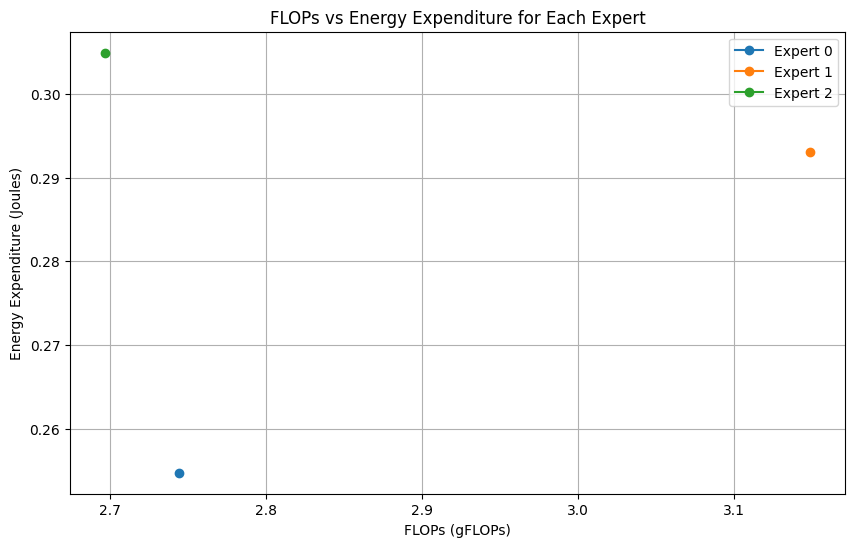

Layer 6 Energy in joules:  19.140060443878173
Layer  6
  Expert 0: 0.2651 J
  Expert 0: 2.8675 gFlops
  Expert 1: 0.2964 J
  Expert 1: 2.7410 gFlops
  Expert 2: 0.3686 J
  Expert 2: 2.9815 gFlops


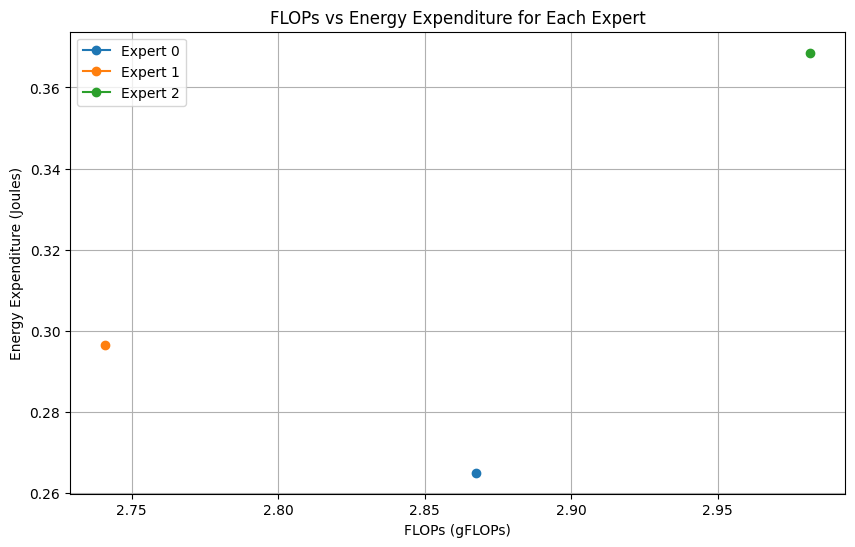

Layer 7 Energy in joules:  21.318675985336302
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.8102 J
  Expert 0: 2.4516 gFlops
  Expert 1: 0.1996 J
  Expert 1: 2.6990 gFlops
  Expert 2: 0.2327 J
  Expert 2: 3.4393 gFlops


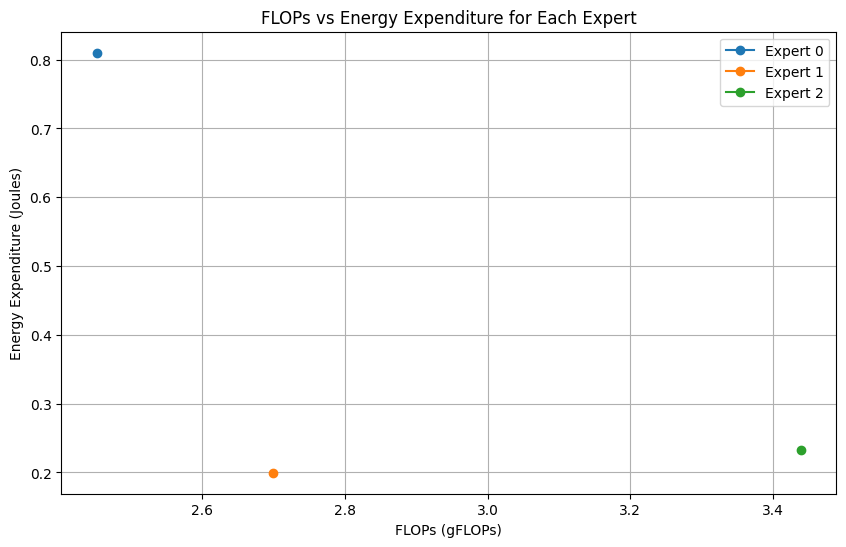

Layer 2 Energy in joules:  20.96067695617676
Layer  2
  Expert 0: 0.2281 J
  Expert 0: 2.5292 gFlops
  Expert 1: 0.2492 J
  Expert 1: 3.4115 gFlops
  Expert 2: 0.2244 J
  Expert 2: 2.6492 gFlops


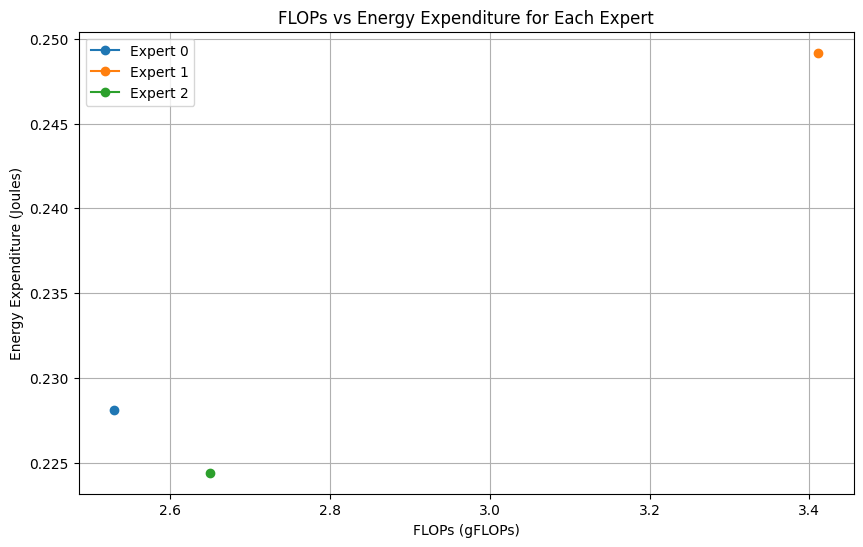

Layer 3 Energy in joules:  19.02538345813751
Layer  3
  Expert 0: 0.2147 J
  Expert 0: 3.0220 gFlops
  Expert 1: 0.2259 J
  Expert 1: 2.3478 gFlops
  Expert 2: 0.2935 J
  Expert 2: 3.2202 gFlops


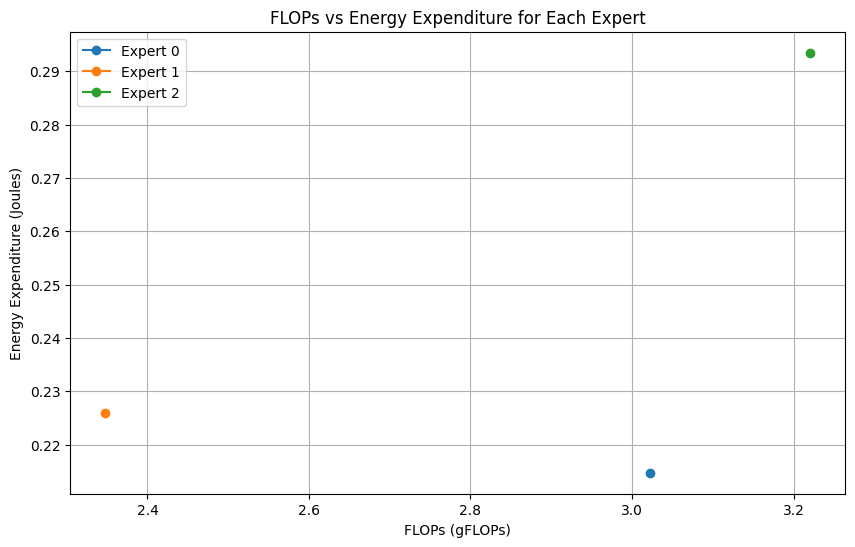

Layer 4 Energy in joules:  18.59935546875
Layer  4
  Expert 0: 0.2216 J
  Expert 0: 2.9669 gFlops
  Expert 1: 0.2550 J
  Expert 1: 2.9276 gFlops
  Expert 2: 0.2649 J
  Expert 2: 2.6954 gFlops


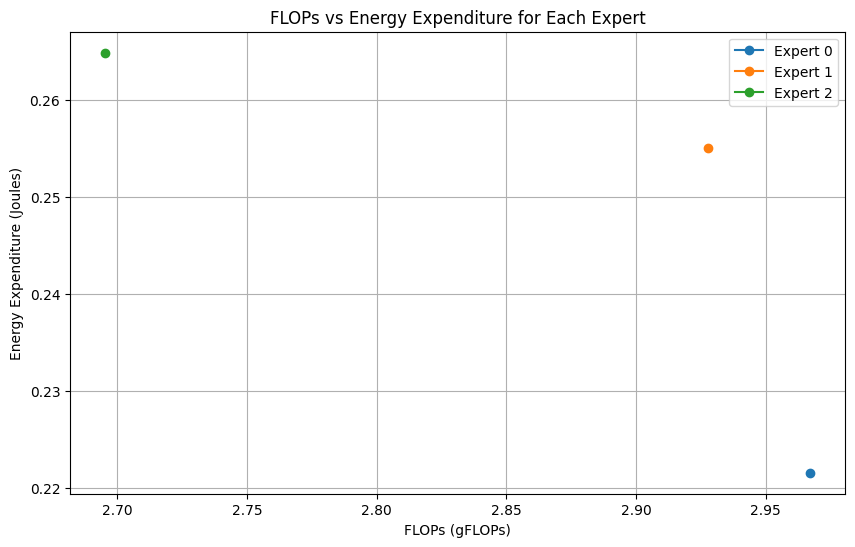

Layer 5 Energy in joules:  13.44296311378479
Layer  5
  Expert 0: 0.1465 J
  Expert 0: 2.7871 gFlops
  Expert 1: 0.1815 J
  Expert 1: 3.1085 gFlops
  Expert 2: 0.1653 J
  Expert 2: 2.6943 gFlops


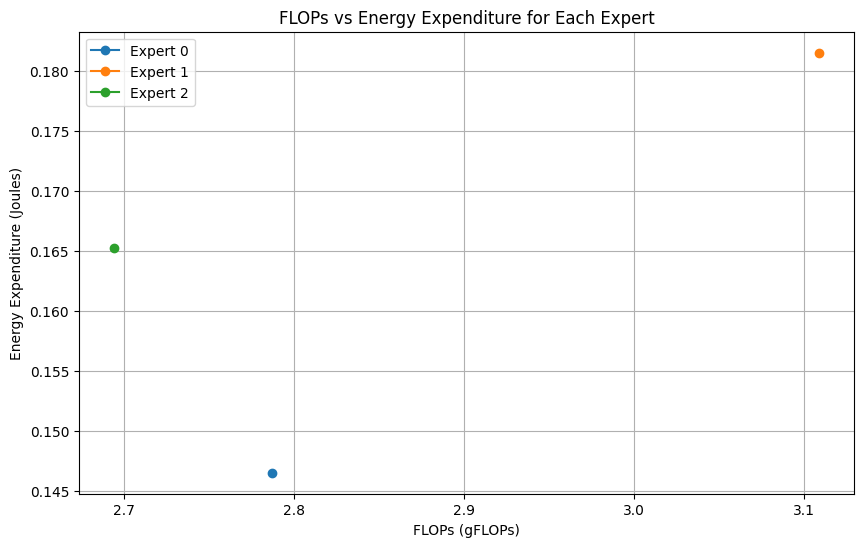

Layer 6 Energy in joules:  13.787680339813233
Layer  6
  Expert 0: 0.1735 J
  Expert 0: 2.8432 gFlops
  Expert 1: 0.1823 J
  Expert 1: 2.7661 gFlops
  Expert 2: 0.2136 J
  Expert 2: 2.9806 gFlops


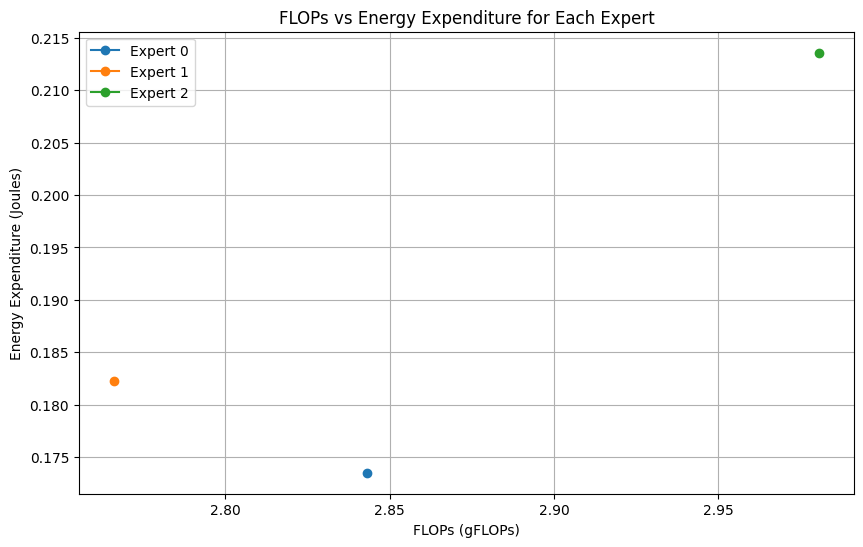

Layer 7 Energy in joules:  13.767475843429565
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.1530 J
  Expert 0: 2.4839 gFlops
  Expert 1: 0.1745 J
  Expert 1: 2.7120 gFlops
  Expert 2: 0.1660 J
  Expert 2: 3.3940 gFlops


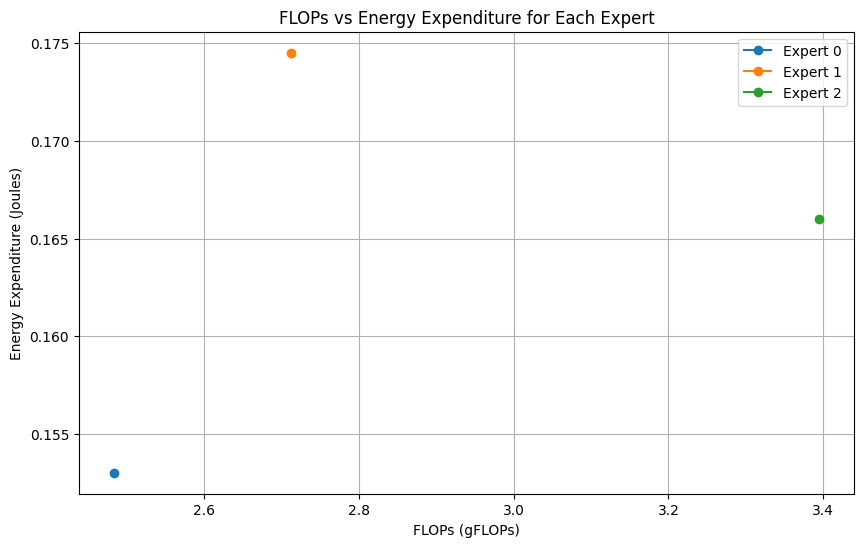

Layer 2 Energy in joules:  20.158089604377746
Layer  2
  Expert 0: 0.1604 J
  Expert 0: 2.5782 gFlops
  Expert 1: 0.1824 J
  Expert 1: 3.3248 gFlops
  Expert 2: 0.1775 J
  Expert 2: 2.6869 gFlops


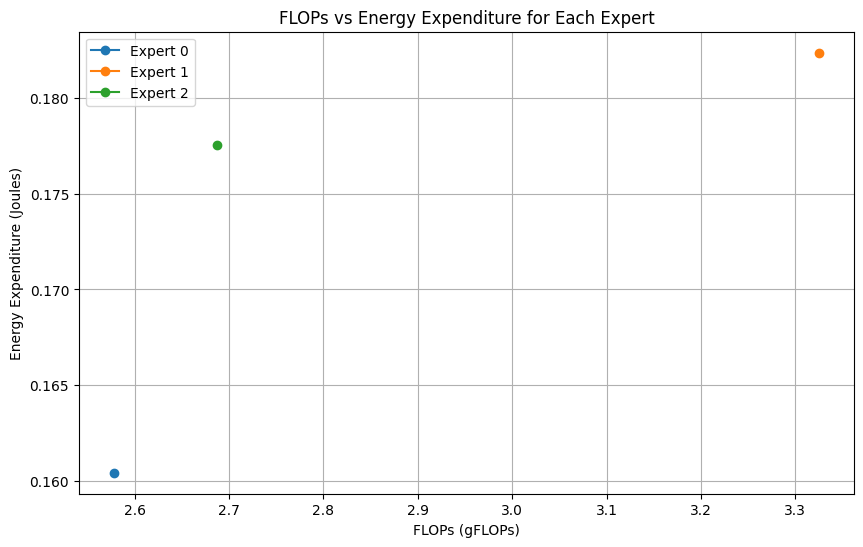

Layer 3 Energy in joules:  20.050711622238158
Layer  3
  Expert 0: 0.1703 J
  Expert 0: 3.0795 gFlops
  Expert 1: 0.1806 J
  Expert 1: 2.3652 gFlops
  Expert 2: 0.1865 J
  Expert 2: 3.1453 gFlops


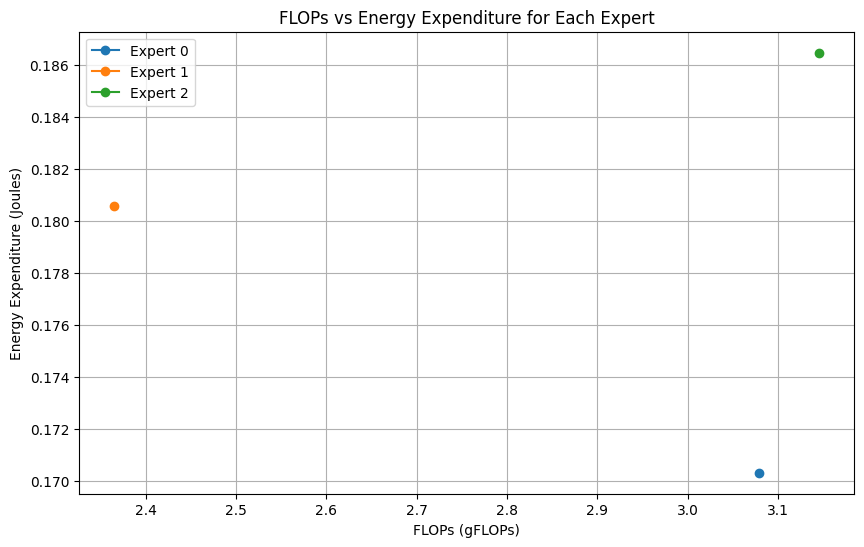

Layer 4 Energy in joules:  19.168642578125
Layer  4
  Expert 0: 0.1795 J
  Expert 0: 3.0254 gFlops
  Expert 1: 0.1955 J
  Expert 1: 2.9373 gFlops
  Expert 2: 0.2097 J
  Expert 2: 2.6273 gFlops


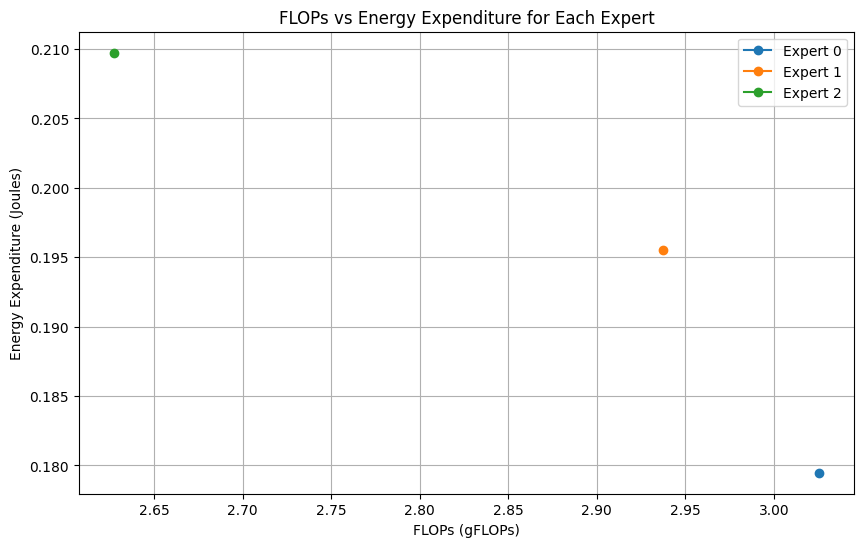

Layer 5 Energy in joules:  14.257890596389771
Layer  5
  Expert 0: 0.1365 J
  Expert 0: 2.8353 gFlops
  Expert 1: 0.1186 J
  Expert 1: 3.0400 gFlops
  Expert 2: 0.1206 J
  Expert 2: 2.7146 gFlops


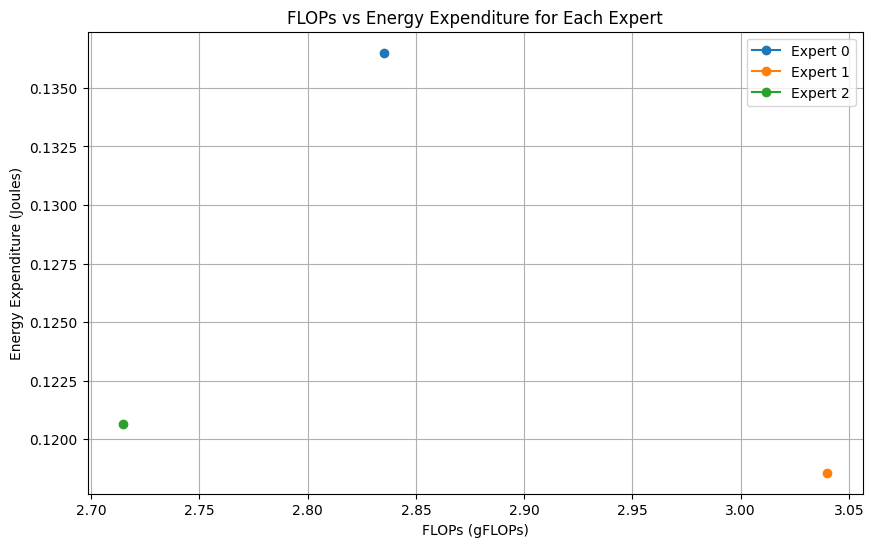

Layer 6 Energy in joules:  14.035685949325563
Layer  6
  Expert 0: 0.1453 J
  Expert 0: 2.8370 gFlops
  Expert 1: 0.1750 J
  Expert 1: 2.7913 gFlops
  Expert 2: 0.1572 J
  Expert 2: 2.9616 gFlops


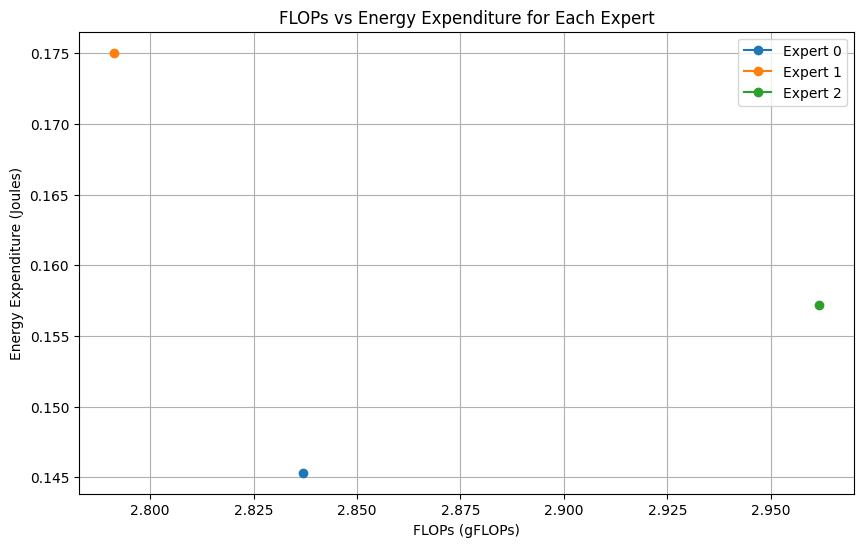

Layer 7 Energy in joules:  14.325635175704956
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090080083385743
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.1555 J
  Expert 0: 2.5515 gFlops
  Expert 1: 0.1375 J
  Expert 1: 2.7368 gFlops
  Expert 2: 0.1318 J
  Expert 2: 3.3016 gFlops


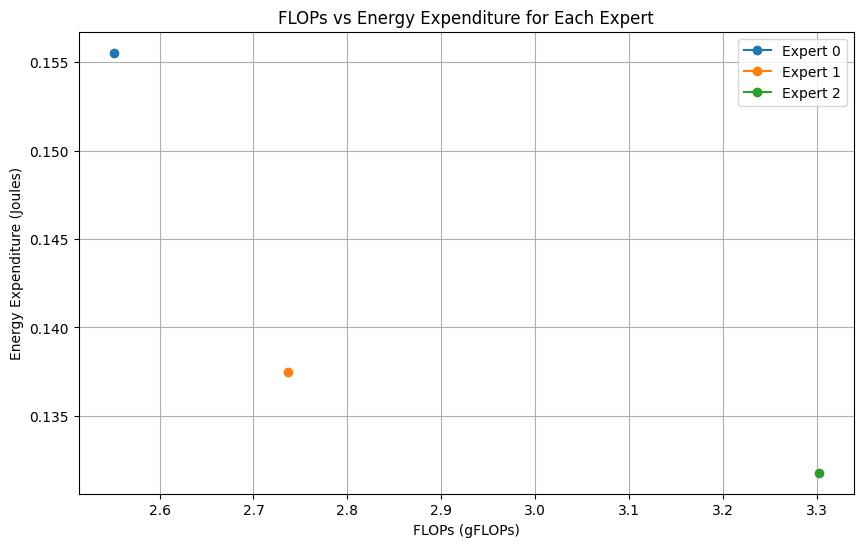

Layer 2 Energy in joules:  19.95790641784668
Layer  2
  Expert 0: 0.1657 J
  Expert 0: 2.6330 gFlops
  Expert 1: 0.1708 J
  Expert 1: 3.1908 gFlops
  Expert 2: 0.1492 J
  Expert 2: 2.7661 gFlops


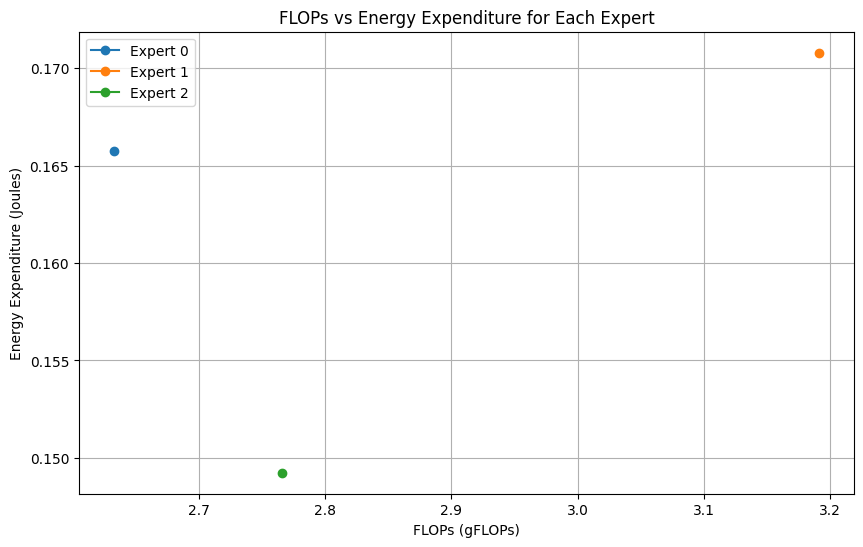

Layer 3 Energy in joules:  17.955261816978457
Layer  3
  Expert 0: 0.1892 J
  Expert 0: 3.1307 gFlops
  Expert 1: 0.1577 J
  Expert 1: 2.4425 gFlops
  Expert 2: 0.1470 J
  Expert 2: 3.0168 gFlops


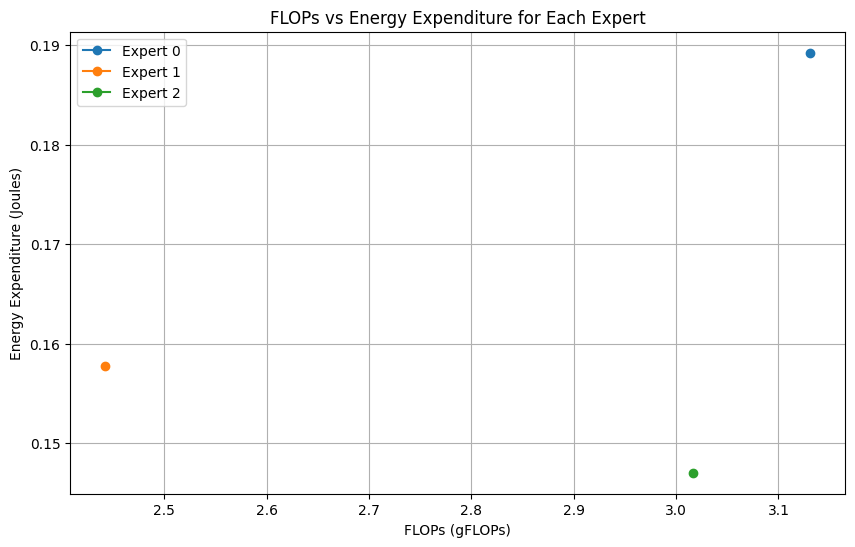

Layer 4 Energy in joules:  19.325724921226502
Layer  4
  Expert 0: 0.1854 J
  Expert 0: 3.0632 gFlops
  Expert 1: 0.2043 J
  Expert 1: 2.8717 gFlops
  Expert 2: 0.2080 J
  Expert 2: 2.6550 gFlops


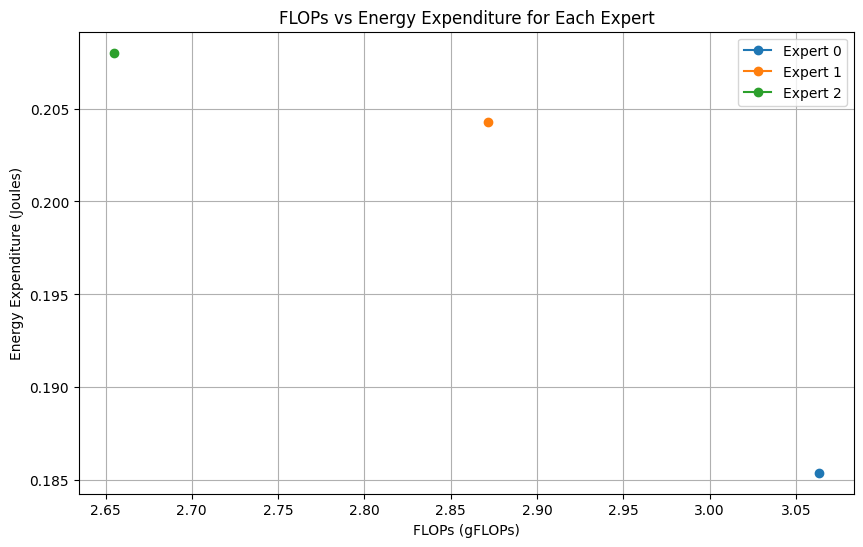

Layer 5 Energy in joules:  17.670807781219484
Layer  5
  Expert 0: 0.1545 J
  Expert 0: 2.9098 gFlops
  Expert 1: 0.1242 J
  Expert 1: 2.9150 gFlops
  Expert 2: 0.1399 J
  Expert 2: 2.7651 gFlops


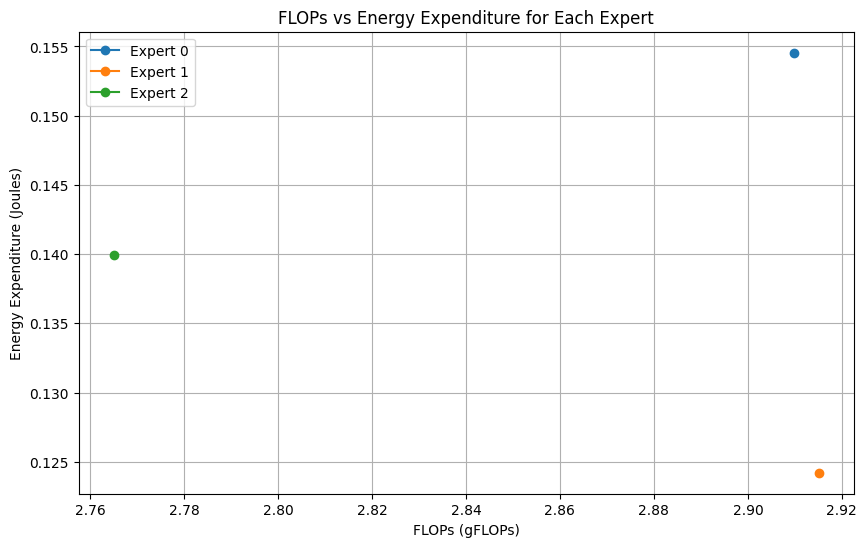

Layer 6 Energy in joules:  21.13277070045471
Layer  6
  Expert 0: 0.1352 J
  Expert 0: 2.8021 gFlops
  Expert 1: 0.1414 J
  Expert 1: 2.8539 gFlops
  Expert 2: 0.1478 J
  Expert 2: 2.9339 gFlops


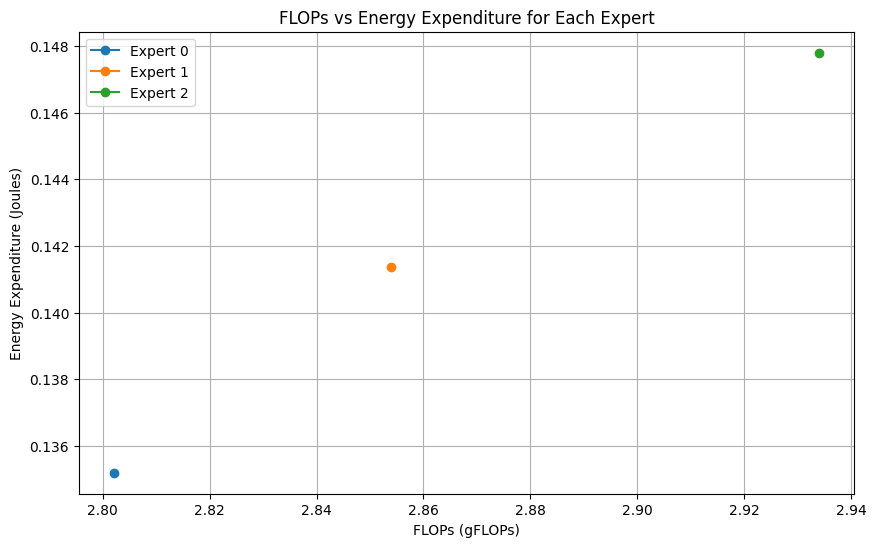

Layer 7 Energy in joules:  20.219215230941774
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Epoch 1/2, Loss: 9.75372870763143, Top-k Accuracy (k=5): 0.1580473960736223
Layer  1
  Expert 0: 0.1294 J
  Expert 0: 2.5525 gFlops
  Expert 1: 0.1353 J
  Expert 1: 2.7476 gFlops
  Expert 2: 0.1318 J
  Expert 2: 3.2898 gFlops


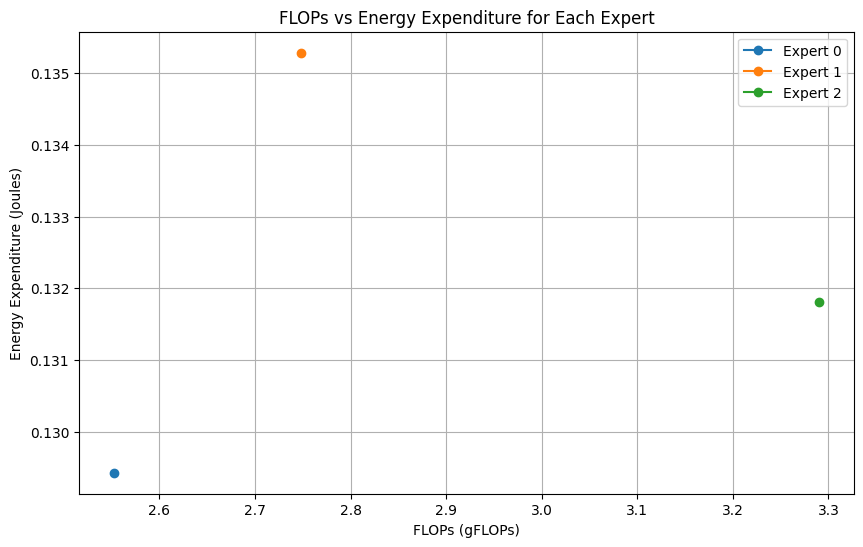

Layer 2 Energy in joules:  20.632069010734558
Layer  2
  Expert 0: 0.1330 J
  Expert 0: 2.6610 gFlops
  Expert 1: 0.1311 J
  Expert 1: 3.1466 gFlops
  Expert 2: 0.1332 J
  Expert 2: 2.7823 gFlops


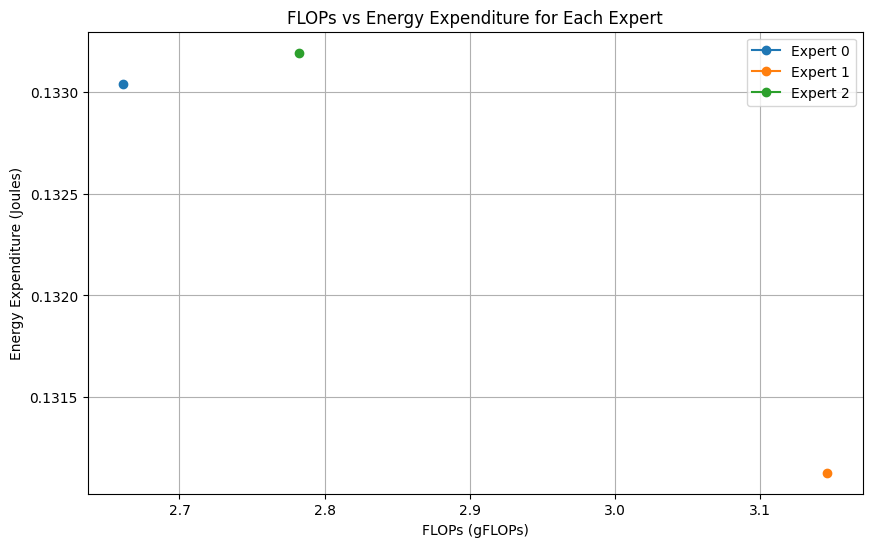

Layer 3 Energy in joules:  16.374025354385374
Layer  3
  Expert 0: 0.1287 J
  Expert 0: 3.1691 gFlops
  Expert 1: 0.1244 J
  Expert 1: 2.4552 gFlops
  Expert 2: 0.1170 J
  Expert 2: 2.9657 gFlops


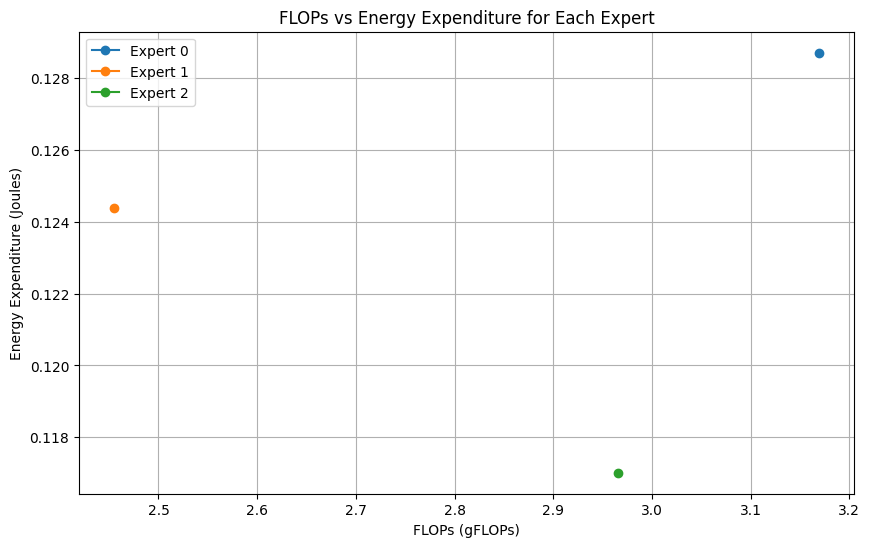

Layer 4 Energy in joules:  16.69105848789215
Layer  4
  Expert 0: 0.1286 J
  Expert 0: 3.0942 gFlops
  Expert 1: 0.1323 J
  Expert 1: 2.8620 gFlops
  Expert 2: 0.1361 J
  Expert 2: 2.6337 gFlops


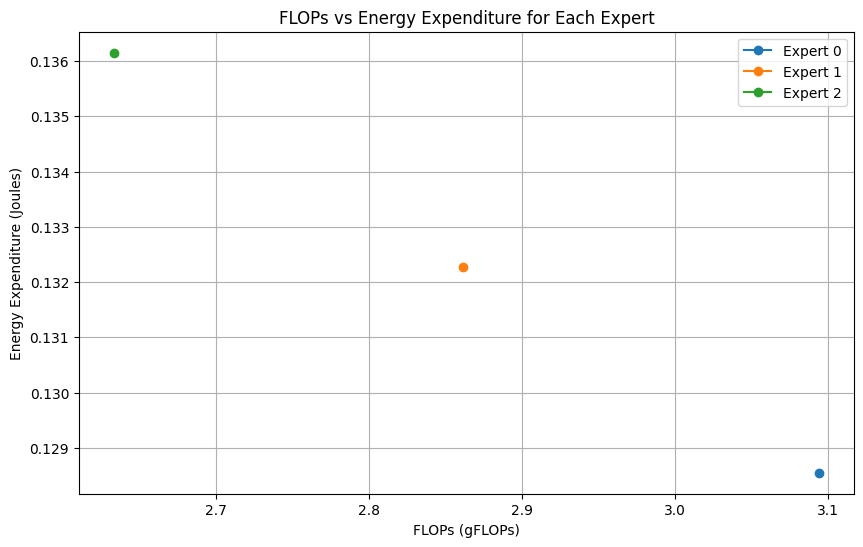

Layer 5 Energy in joules:  14.107446184158325
Layer  5
  Expert 0: 0.0874 J
  Expert 0: 2.9534 gFlops
  Expert 1: 0.1054 J
  Expert 1: 2.8779 gFlops
  Expert 2: 0.0956 J
  Expert 2: 2.7587 gFlops


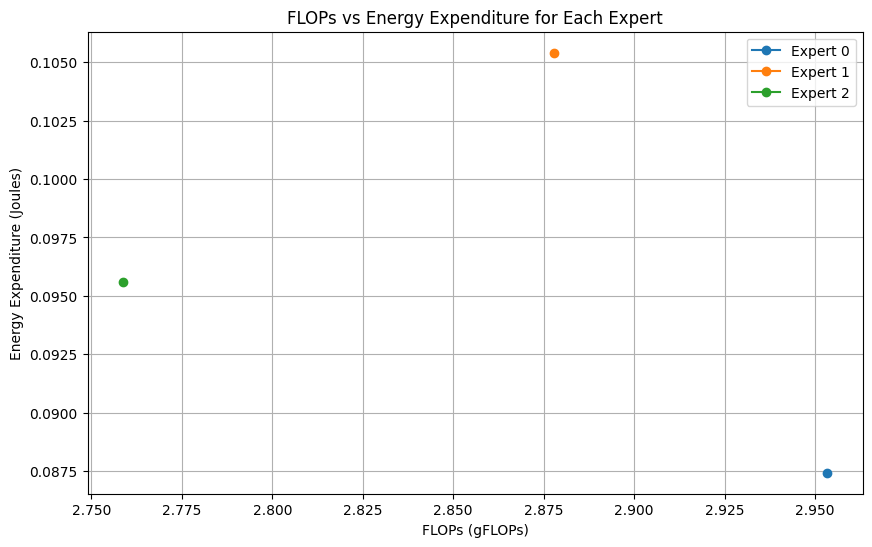

Layer 6 Energy in joules:  14.682729148864746
Layer  6
  Expert 0: 0.0797 J
  Expert 0: 2.7416 gFlops
  Expert 1: 0.0929 J
  Expert 1: 2.9501 gFlops
  Expert 2: 0.1043 J
  Expert 2: 2.8983 gFlops


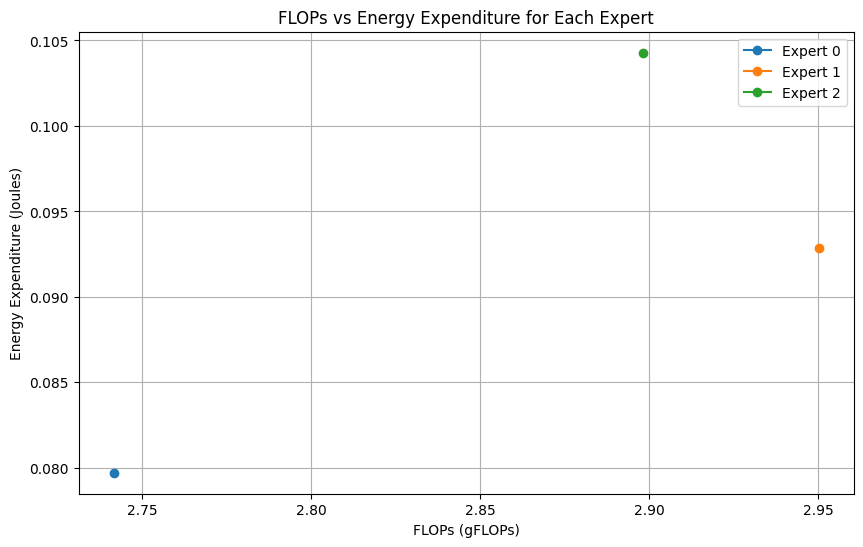

Layer 7 Energy in joules:  14.191938943862915
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.3489 J
  Expert 0: 2.5784 gFlops
  Expert 1: 0.1135 J
  Expert 1: 2.7690 gFlops
  Expert 2: 0.1437 J
  Expert 2: 3.2425 gFlops


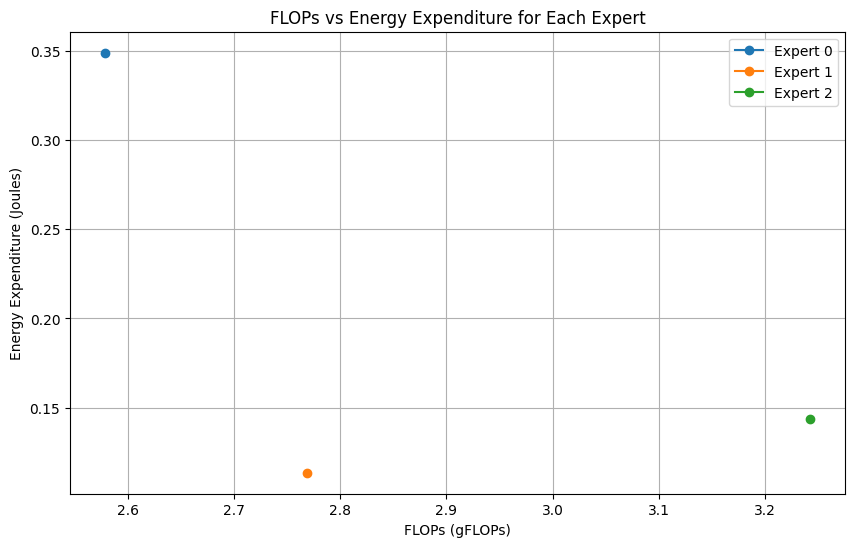

Layer 2 Energy in joules:  18.92954797267914
Layer  2
  Expert 0: 0.0874 J
  Expert 0: 2.7145 gFlops
  Expert 1: 0.1071 J
  Expert 1: 3.0713 gFlops
  Expert 2: 0.0958 J
  Expert 2: 2.8042 gFlops


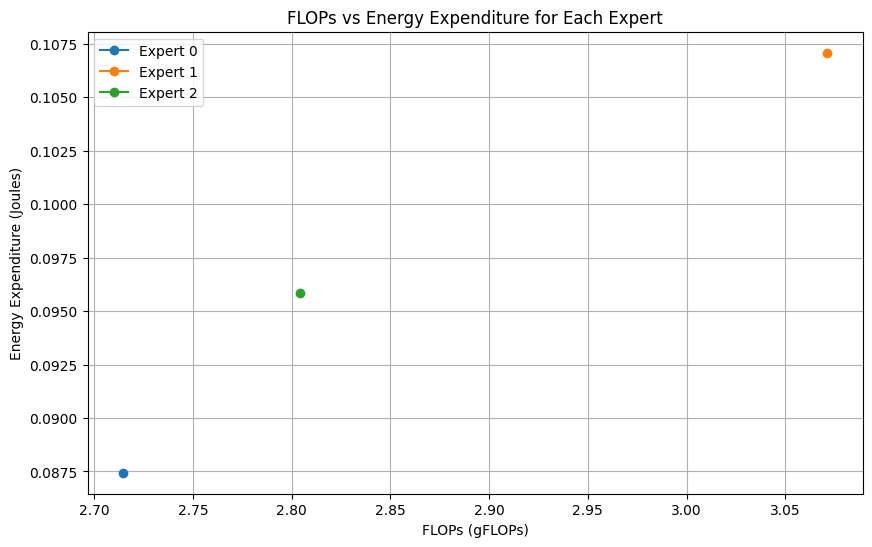

Layer 3 Energy in joules:  17.856026179790497
Layer  3
  Expert 0: 0.1165 J
  Expert 0: 3.2024 gFlops
  Expert 1: 0.1040 J
  Expert 1: 2.4933 gFlops
  Expert 2: 0.1439 J
  Expert 2: 2.8943 gFlops


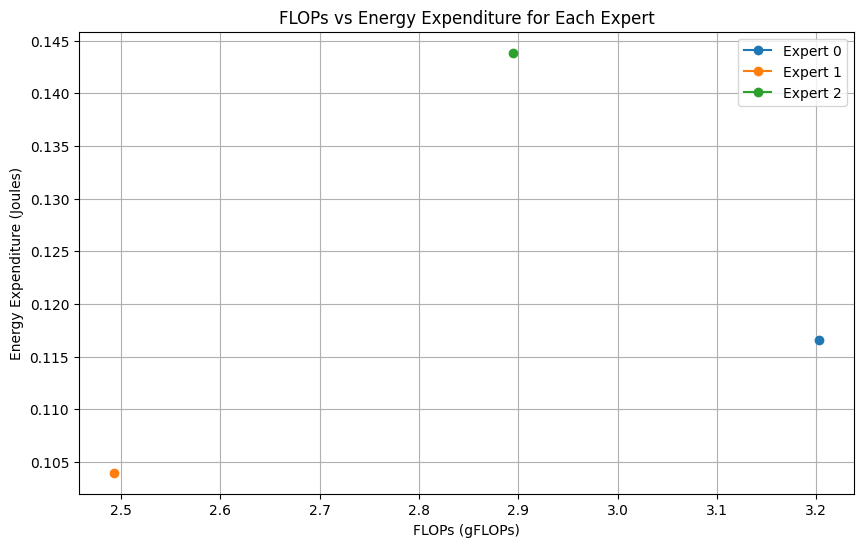

Layer 4 Energy in joules:  17.6310378742218
Layer  4
  Expert 0: 0.1052 J
  Expert 0: 3.1316 gFlops
  Expert 1: 0.0995 J
  Expert 1: 2.8120 gFlops
  Expert 2: 0.1053 J
  Expert 2: 2.6463 gFlops


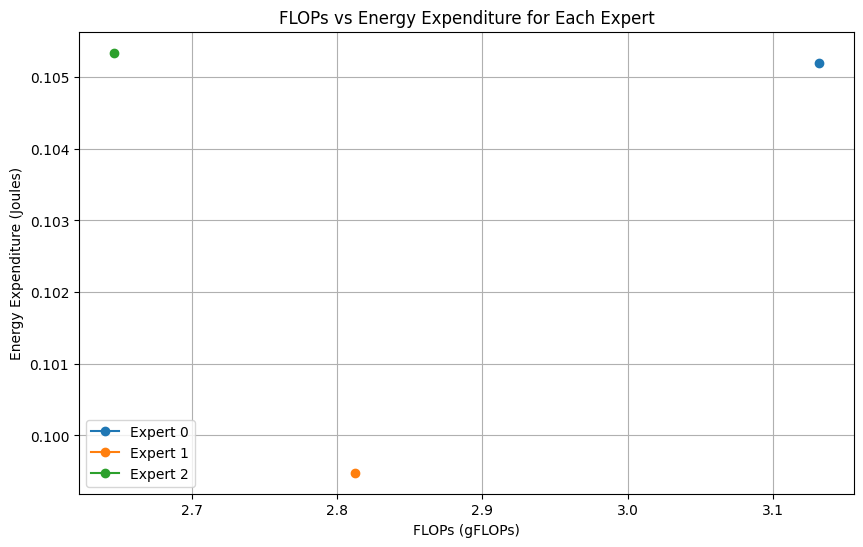

Layer 5 Energy in joules:  13.416306538581848
Layer  5
  Expert 0: 0.0816 J
  Expert 0: 3.0267 gFlops
  Expert 1: 0.0828 J
  Expert 1: 2.8160 gFlops
  Expert 2: 0.1065 J
  Expert 2: 2.7473 gFlops


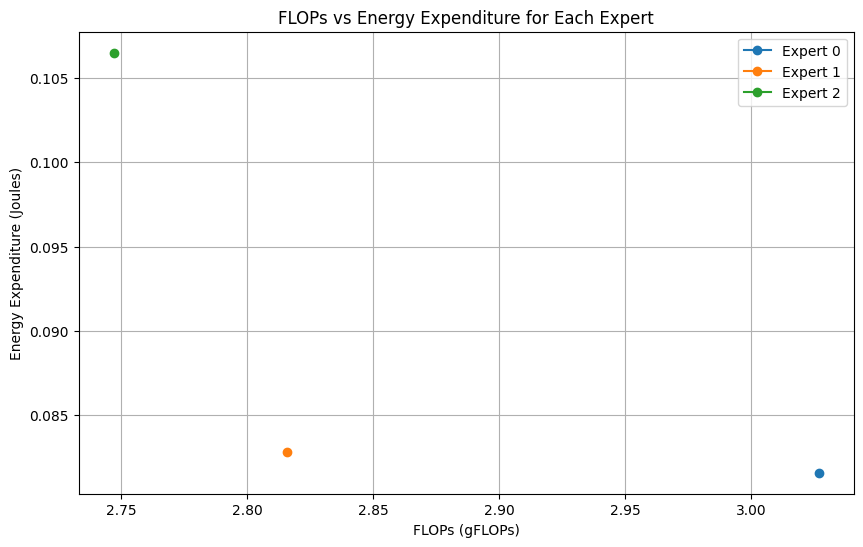

Layer 6 Energy in joules:  13.31714973449707
Layer  6
  Expert 0: 0.0889 J
  Expert 0: 2.6718 gFlops
  Expert 1: 0.0790 J
  Expert 1: 3.0369 gFlops
  Expert 2: 0.0771 J
  Expert 2: 2.8812 gFlops


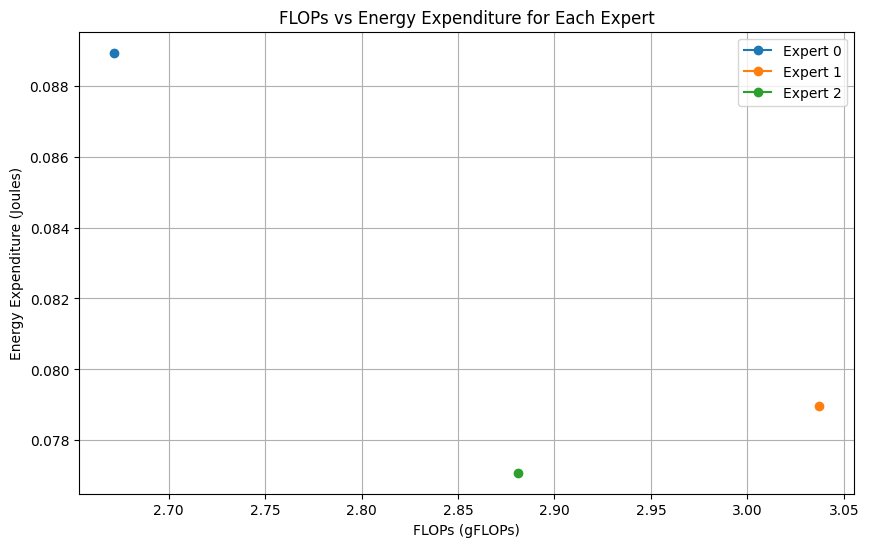

Layer 7 Energy in joules:  13.66568172454834
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.2841 J
  Expert 0: 2.5653 gFlops
  Expert 1: 0.2111 J
  Expert 1: 2.7657 gFlops
  Expert 2: 0.0887 J
  Expert 2: 3.2590 gFlops


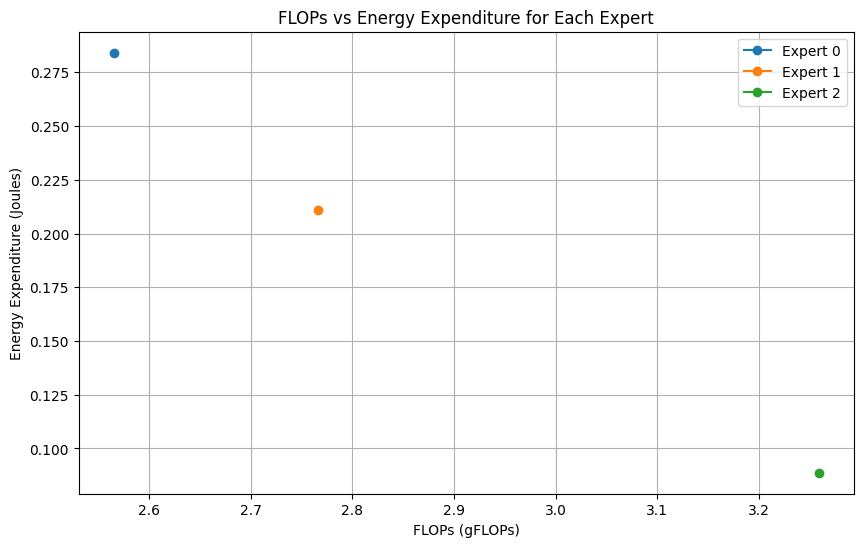

Layer 2 Energy in joules:  26.203994140625
Layer  2
  Expert 0: 0.1160 J
  Expert 0: 2.7212 gFlops
  Expert 1: 0.1190 J
  Expert 1: 3.0749 gFlops
  Expert 2: 0.5884 J
  Expert 2: 2.7939 gFlops


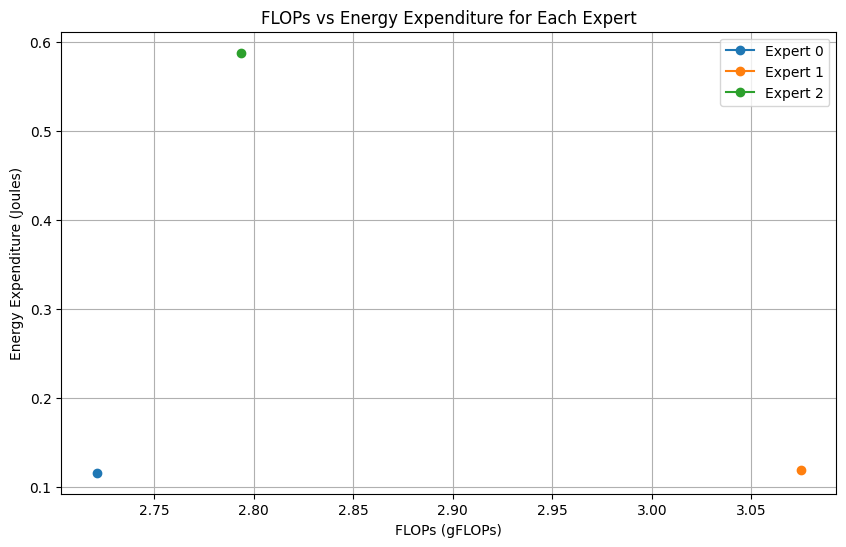

Layer 3 Energy in joules:  40.93335050106049
Layer  3
  Expert 0: 0.0891 J
  Expert 0: 3.2135 gFlops
  Expert 1: 0.0958 J
  Expert 1: 2.4749 gFlops
  Expert 2: 0.0872 J
  Expert 2: 2.9015 gFlops


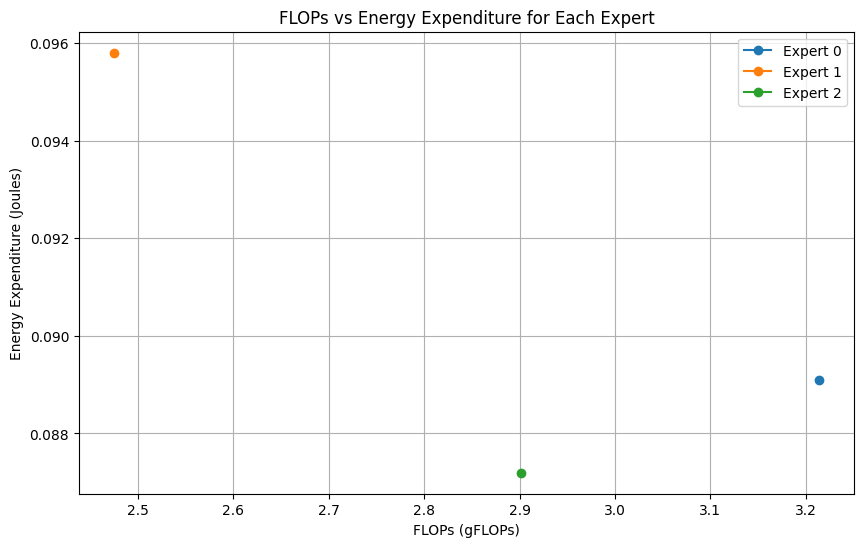

Layer 4 Energy in joules:  17.569659004211427
Layer  4
  Expert 0: 0.1029 J
  Expert 0: 3.1345 gFlops
  Expert 1: 0.0884 J
  Expert 1: 2.8384 gFlops
  Expert 2: 0.0928 J
  Expert 2: 2.6170 gFlops


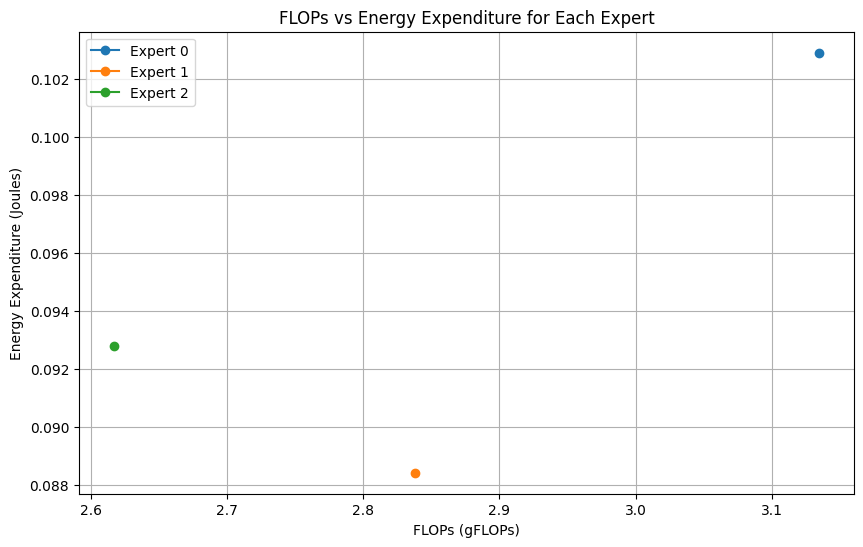

Layer 5 Energy in joules:  18.789490456581117
Layer  5
  Expert 0: 0.0963 J
  Expert 0: 3.0763 gFlops
  Expert 1: 0.0865 J
  Expert 1: 2.8358 gFlops
  Expert 2: 0.0854 J
  Expert 2: 2.6778 gFlops


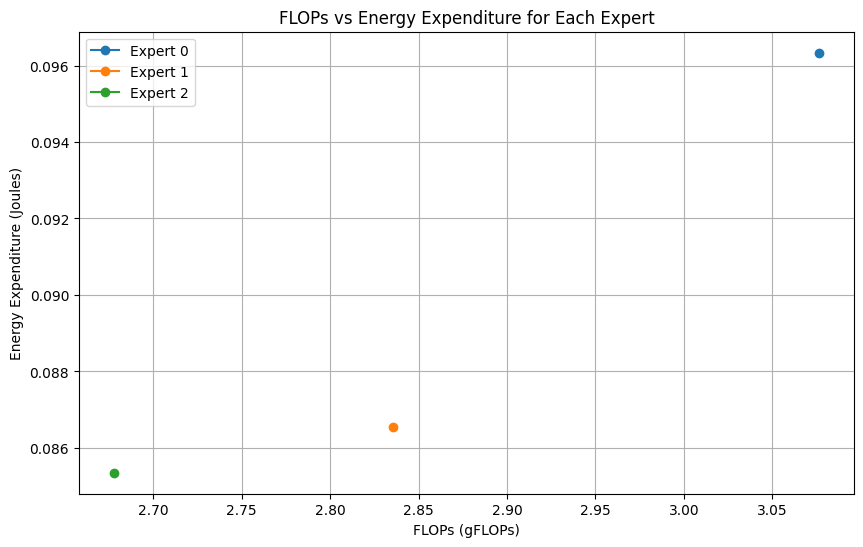

Layer 6 Energy in joules:  21.789934000968934
Layer  6
  Expert 0: 0.0856 J
  Expert 0: 2.6510 gFlops
  Expert 1: 0.0935 J
  Expert 1: 3.0698 gFlops
  Expert 2: 0.0963 J
  Expert 2: 2.8691 gFlops


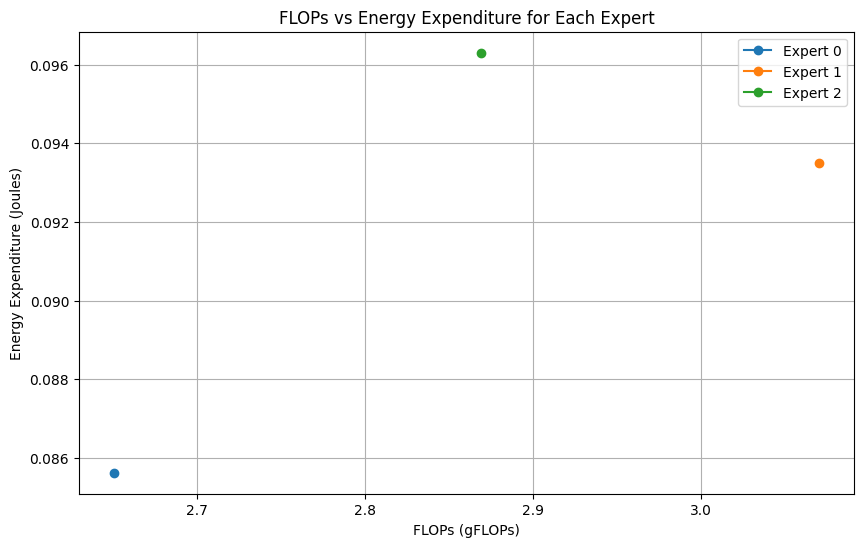

Layer 7 Energy in joules:  20.19292443752289
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.090081990734376
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.0694 J
  Expert 0: 2.5791 gFlops
  Expert 1: 0.2823 J
  Expert 1: 2.7710 gFlops
  Expert 2: 0.1017 J
  Expert 2: 3.2399 gFlops


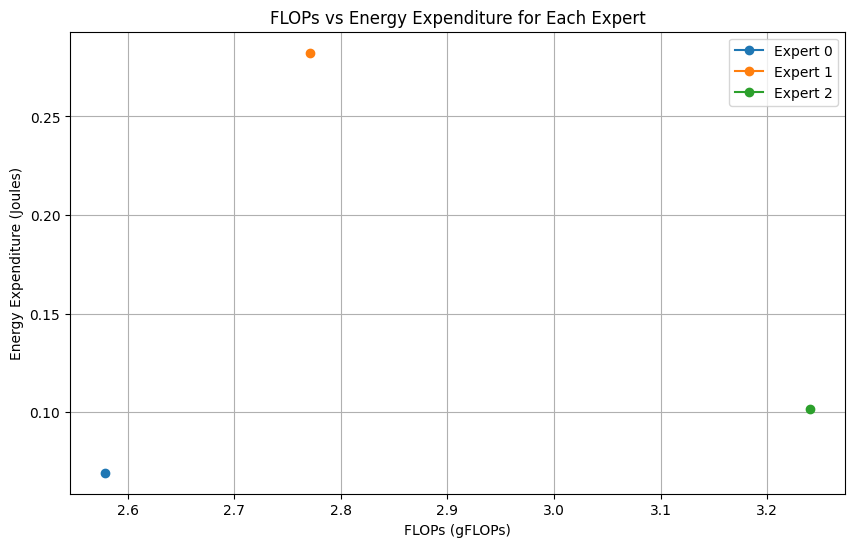

Layer 2 Energy in joules:  21.36179141998291
Layer  2
  Expert 0: 0.0781 J
  Expert 0: 2.7410 gFlops
  Expert 1: 0.1135 J
  Expert 1: 3.0511 gFlops
  Expert 2: 0.1027 J
  Expert 2: 2.7978 gFlops


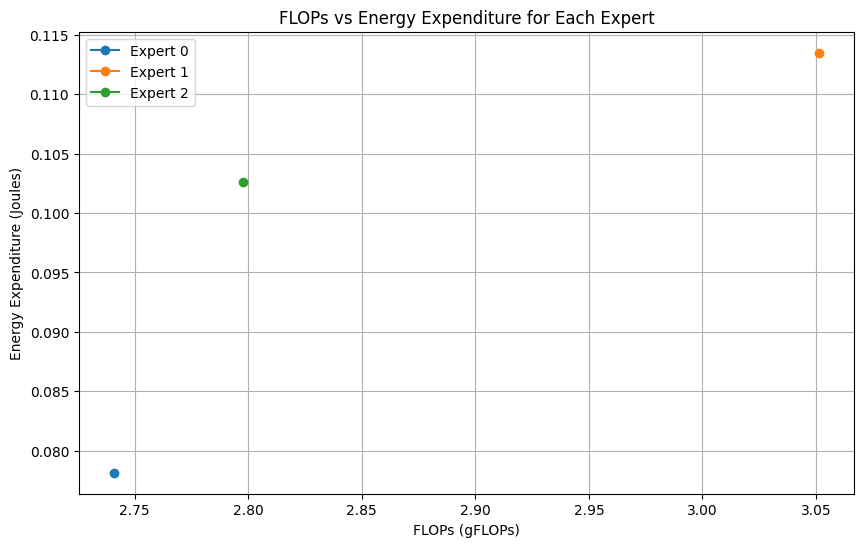

Layer 3 Energy in joules:  18.739358682632446
Layer  3
  Expert 0: 0.0939 J
  Expert 0: 3.2321 gFlops
  Expert 1: 0.0940 J
  Expert 1: 2.4782 gFlops
  Expert 2: 0.1104 J
  Expert 2: 2.8796 gFlops


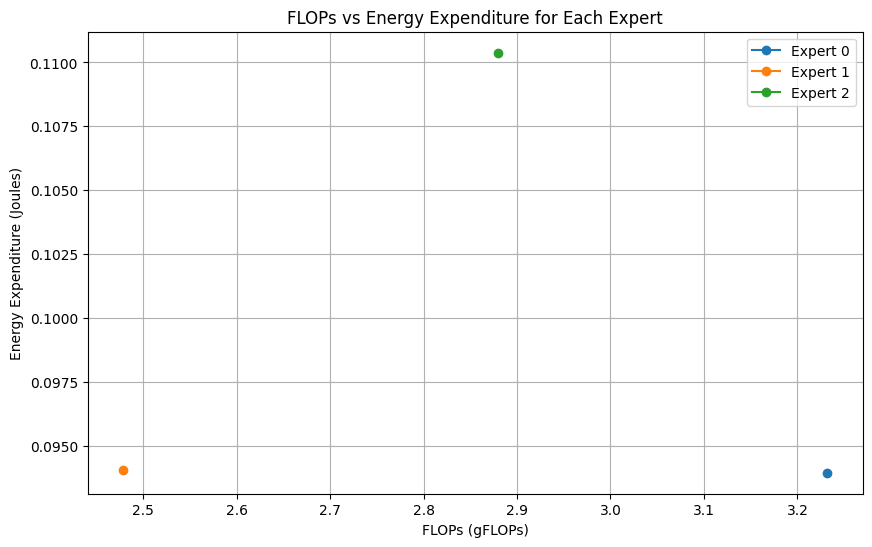

Layer 4 Energy in joules:  19.745986092090607
Layer  4
  Expert 0: 0.0817 J
  Expert 0: 3.1478 gFlops
  Expert 1: 0.0807 J
  Expert 1: 2.8309 gFlops
  Expert 2: 0.0855 J
  Expert 2: 2.6112 gFlops


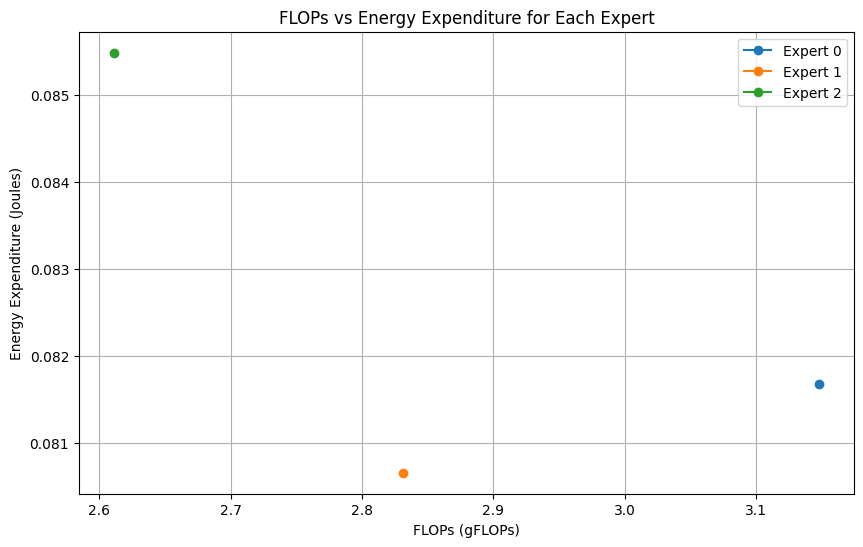

Layer 5 Energy in joules:  18.44513934612274
Layer  5
  Expert 0: 0.0666 J
  Expert 0: 3.1331 gFlops
  Expert 1: 0.0712 J
  Expert 1: 2.8217 gFlops
  Expert 2: 0.0786 J
  Expert 2: 2.6351 gFlops


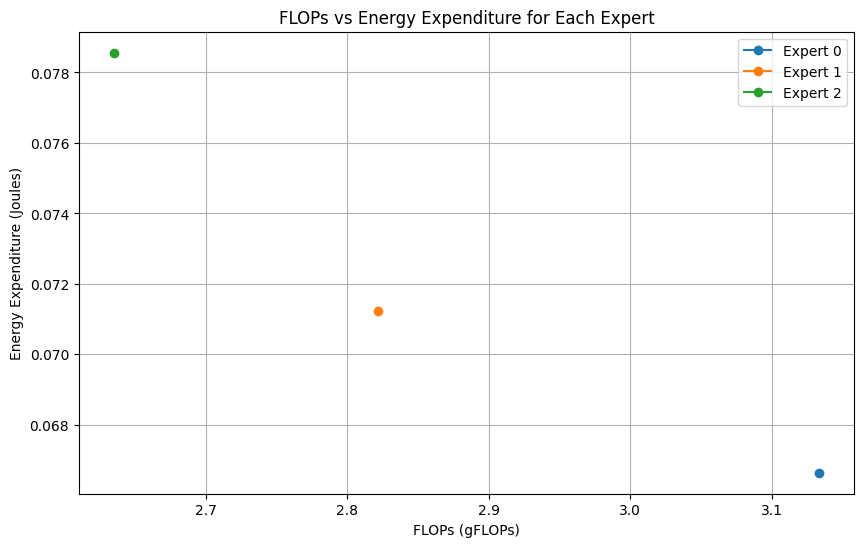

Layer 6 Energy in joules:  14.161376640796663
Layer  6
  Expert 0: 0.0649 J
  Expert 0: 2.6533 gFlops
  Expert 1: 0.0621 J
  Expert 1: 3.0671 gFlops
  Expert 2: 0.0643 J
  Expert 2: 2.8695 gFlops


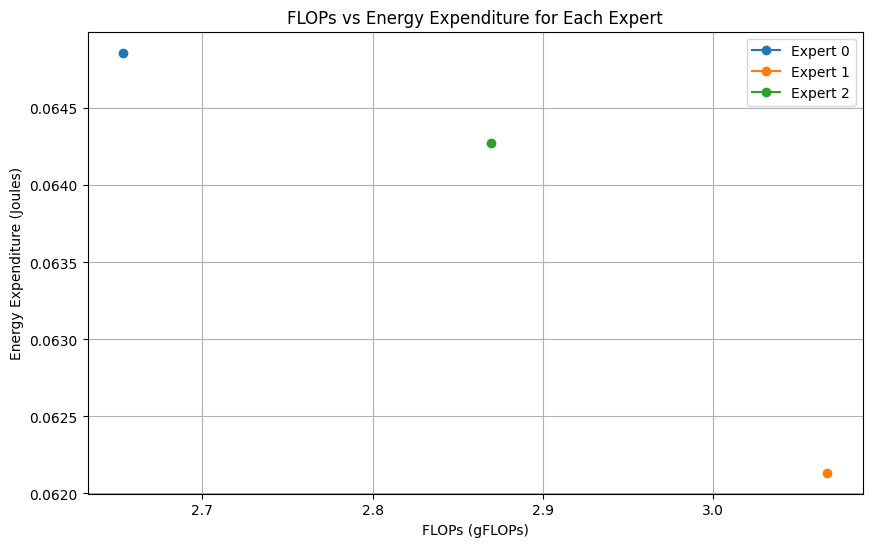

Layer 7 Energy in joules:  13.378684844970703
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.090080083385743
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.0898 J
  Expert 0: 2.5835 gFlops
  Expert 1: 0.0865 J
  Expert 1: 2.7806 gFlops
  Expert 2: 0.0950 J
  Expert 2: 3.2258 gFlops


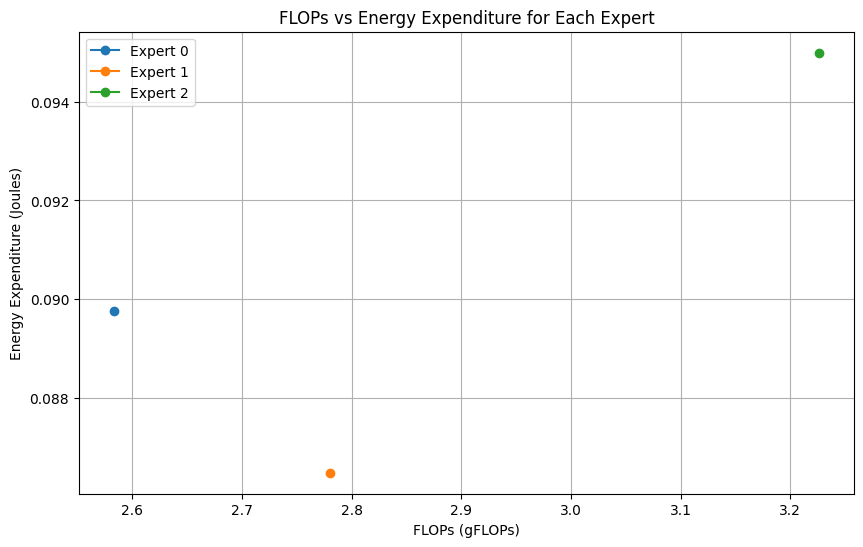

Layer 2 Energy in joules:  21.13087008476257
Layer  2
  Expert 0: 0.0816 J
  Expert 0: 2.7564 gFlops
  Expert 1: 0.1200 J
  Expert 1: 3.0275 gFlops
  Expert 2: 0.0989 J
  Expert 2: 2.8060 gFlops


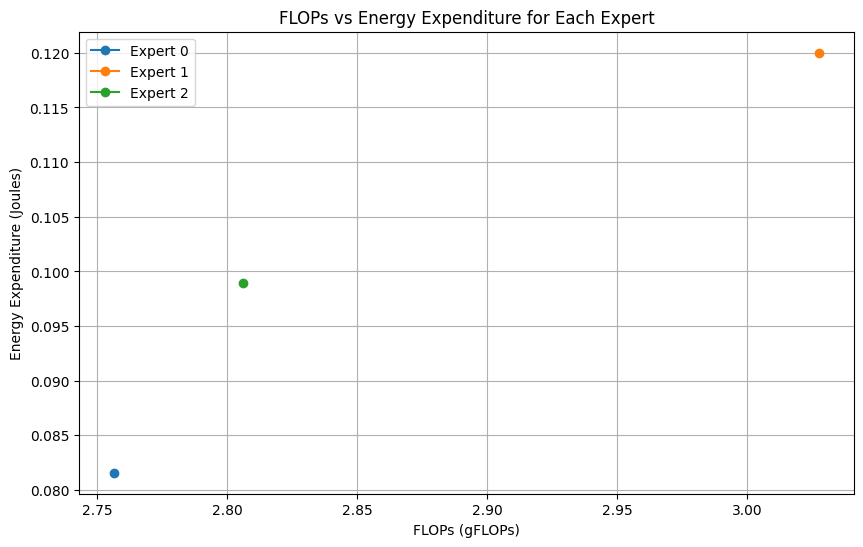

Layer 3 Energy in joules:  20.71037935733795
Layer  3
  Expert 0: 0.0781 J
  Expert 0: 3.2418 gFlops
  Expert 1: 0.0770 J
  Expert 1: 2.4882 gFlops
  Expert 2: 0.0817 J
  Expert 2: 2.8599 gFlops


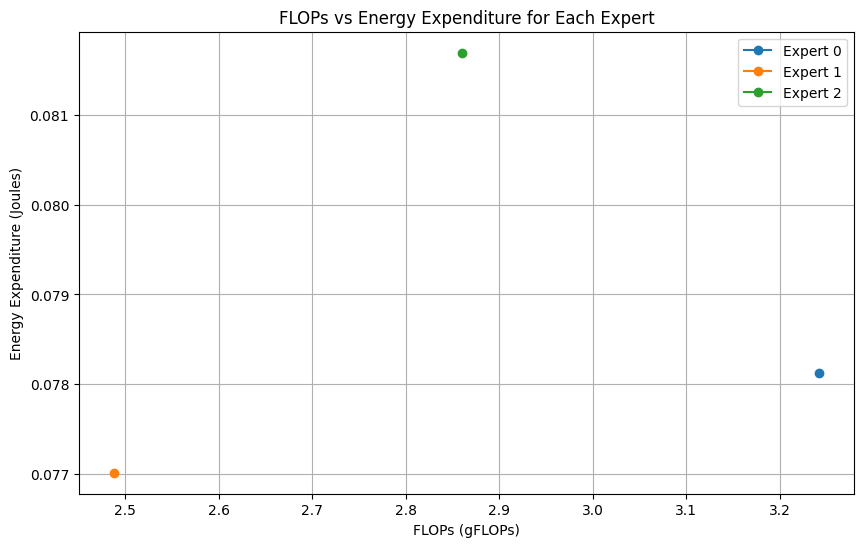

Layer 4 Energy in joules:  18.937587893009187
Layer  4
  Expert 0: 0.0765 J
  Expert 0: 3.1667 gFlops
  Expert 1: 0.0748 J
  Expert 1: 2.8195 gFlops
  Expert 2: 0.0791 J
  Expert 2: 2.6037 gFlops


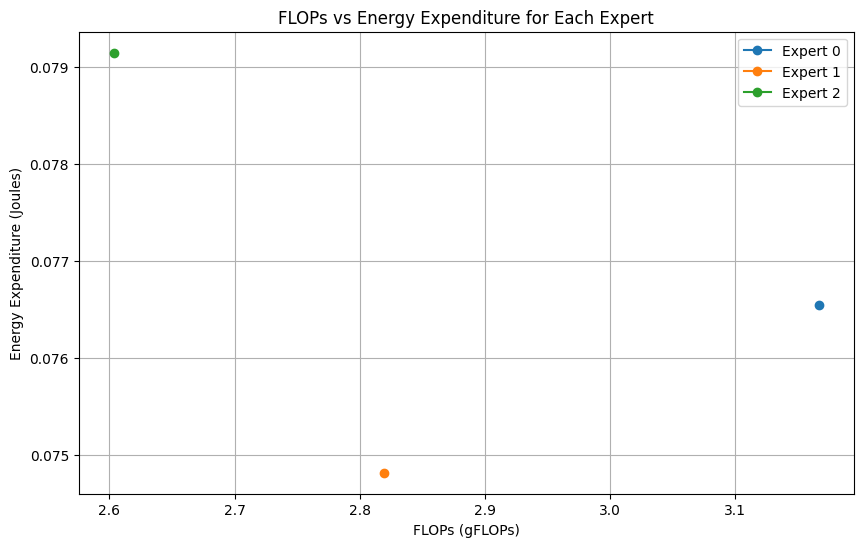

Layer 5 Energy in joules:  13.786730189323425
Layer  5
  Expert 0: 0.0583 J
  Expert 0: 3.1915 gFlops
  Expert 1: 0.0566 J
  Expert 1: 2.8130 gFlops
  Expert 2: 0.0841 J
  Expert 2: 2.5854 gFlops


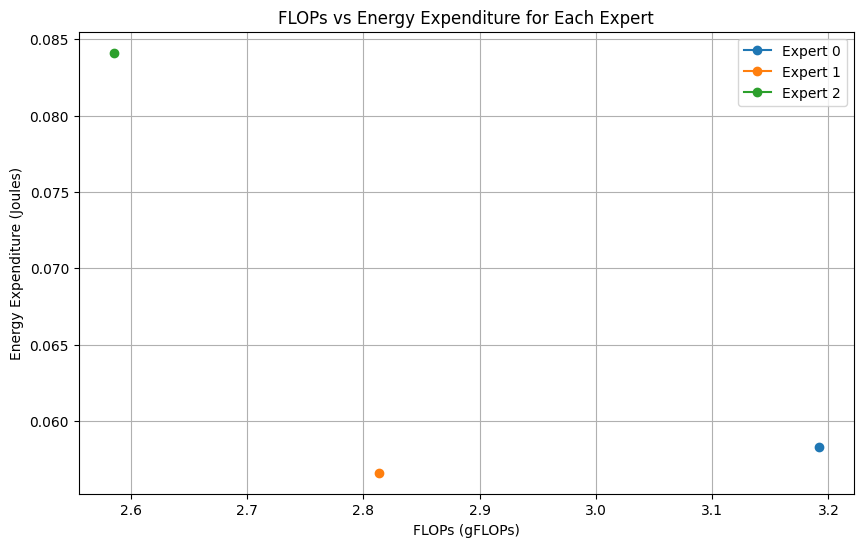

Layer 6 Energy in joules:  14.377991676330566
Layer  6
  Expert 0: 0.0635 J
  Expert 0: 2.6561 gFlops
  Expert 1: 0.0634 J
  Expert 1: 3.0540 gFlops
  Expert 2: 0.0565 J
  Expert 2: 2.8798 gFlops


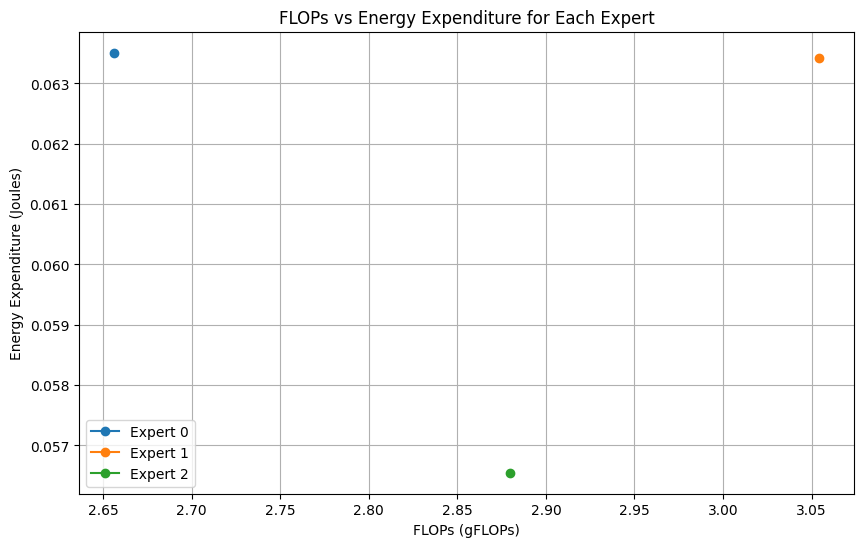

Layer 7 Energy in joules:  15.36809536457062
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.0573 J
  Expert 0: 2.6064 gFlops
  Expert 1: 0.0634 J
  Expert 1: 2.7889 gFlops
  Expert 2: 0.0950 J
  Expert 2: 3.1947 gFlops


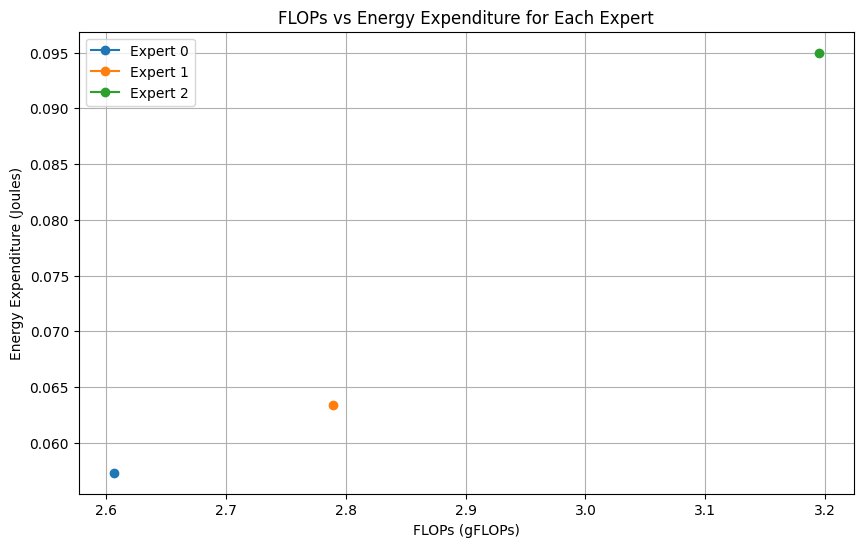

Layer 2 Energy in joules:  22.102699041366577
Layer  2
  Expert 0: 0.0761 J
  Expert 0: 2.7873 gFlops
  Expert 1: 0.0871 J
  Expert 1: 2.9808 gFlops
  Expert 2: 0.0774 J
  Expert 2: 2.8219 gFlops


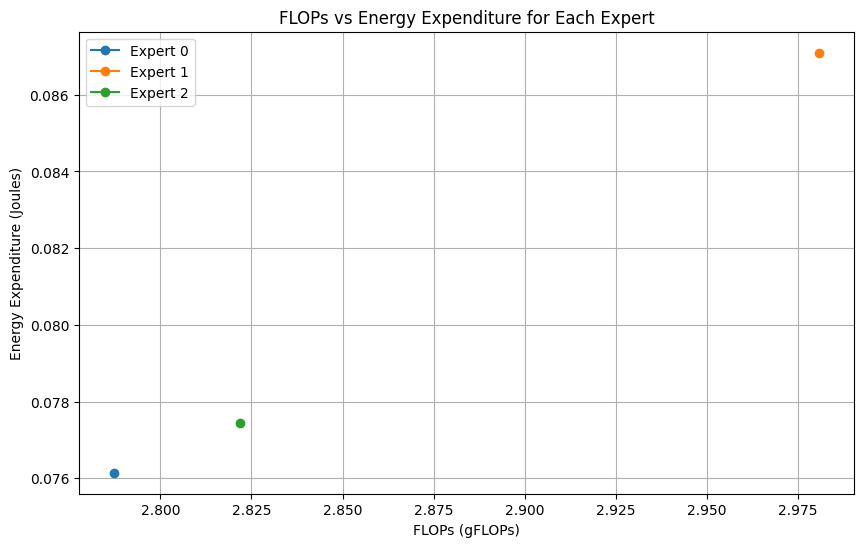

Layer 3 Energy in joules:  20.034977686405185
Layer  3
  Expert 0: 0.0824 J
  Expert 0: 3.2675 gFlops
  Expert 1: 0.0810 J
  Expert 1: 2.5112 gFlops
  Expert 2: 0.0831 J
  Expert 2: 2.8112 gFlops


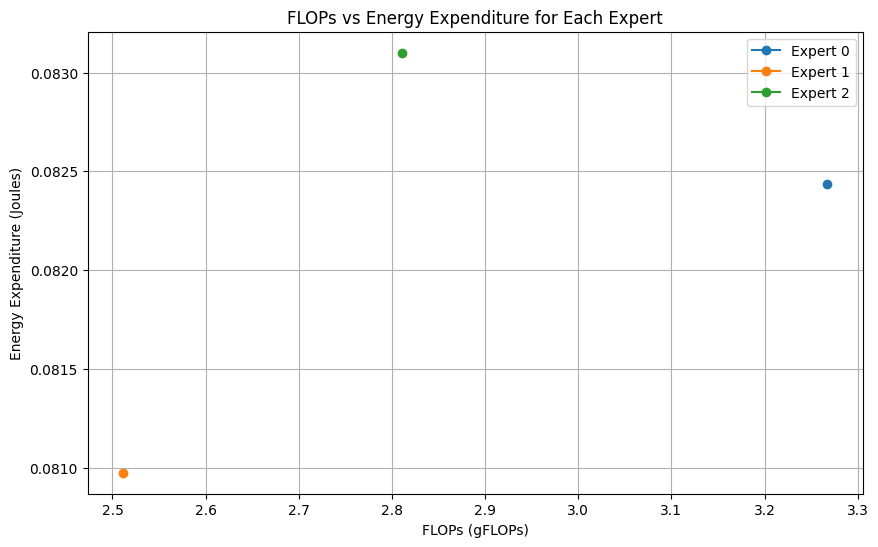

Layer 4 Energy in joules:  24.23871748447418
Layer  4
  Expert 0: 0.0920 J
  Expert 0: 3.1961 gFlops
  Expert 1: 0.1034 J
  Expert 1: 2.7841 gFlops
  Expert 2: 0.0914 J
  Expert 2: 2.6097 gFlops


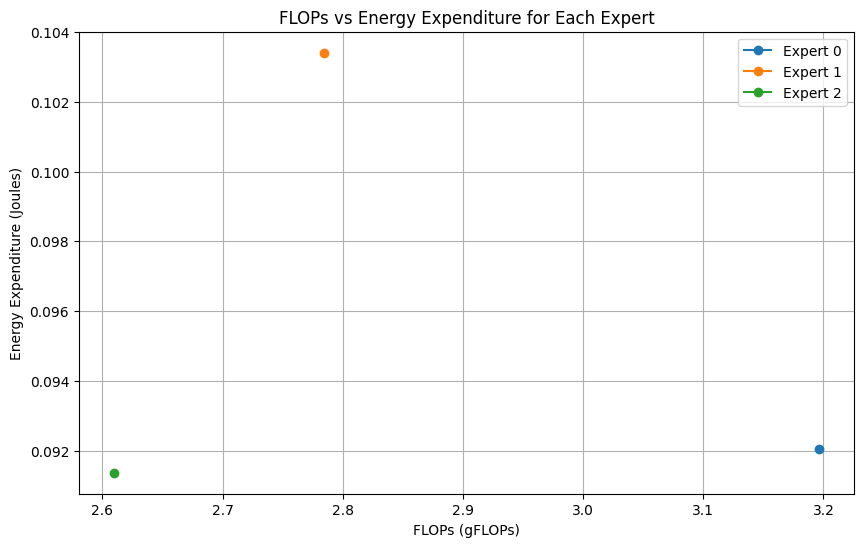

Layer 5 Energy in joules:  21.18399543762207
Layer  5
  Expert 0: 0.0623 J
  Expert 0: 3.2579 gFlops
  Expert 1: 0.0851 J
  Expert 1: 2.7779 gFlops
  Expert 2: 0.0782 J
  Expert 2: 2.5542 gFlops


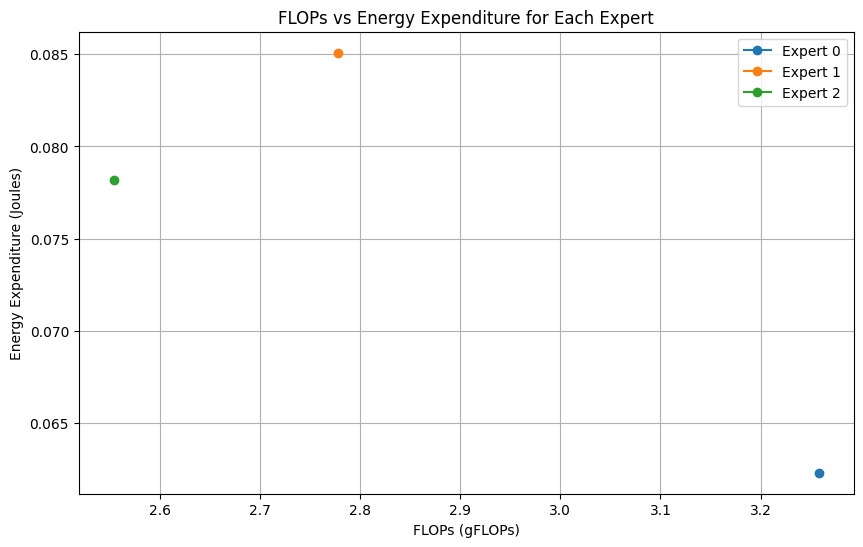

Layer 6 Energy in joules:  18.960886373519898
Layer  6
  Expert 0: 0.0743 J
  Expert 0: 2.6511 gFlops
  Expert 1: 0.0638 J
  Expert 1: 3.0285 gFlops
  Expert 2: 0.0683 J
  Expert 2: 2.9103 gFlops


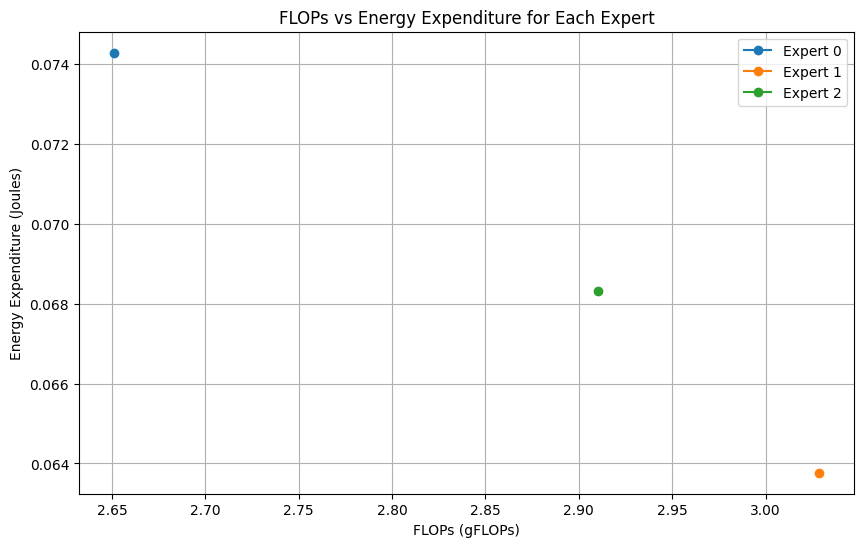

Layer 7 Energy in joules:  21.754489831924438
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.090081990734376
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Epoch 2/2, Loss: 8.859901746114096, Top-k Accuracy (k=5): 0.2877042641242345


In [10]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import random

# Create DataLoader
batch_size = 16
from torch.nn.utils.rnn import pad_sequence

def perturb_input(input_ids, tokenizer, noise_type="substitution", dropout_prob=0.1, substitution_prob=0.1):
    """
    Perturbs the input tokenized text by applying dropout or substitution noise.

    input_ids: Tensor of shape (batch_size, seq_len)
    tokenizer: The tokenizer used to encode text.
    noise_type: Type of noise ('dropout' or 'substitution')
    dropout_prob: Probability of dropping tokens.
    substitution_prob: Probability of substituting tokens with random tokens.
    """
    batch_size, seq_len = input_ids.size()

    if noise_type == "dropout":
        # Word Dropout: Randomly set some token indices to the pad token
        for i in range(batch_size):
            for j in range(seq_len):
                if random.random() < dropout_prob:
                    input_ids[i, j] = tokenizer.pad_token_id

    elif noise_type == "substitution":
        # Word Substitution: Replace tokens with random tokens from the vocabulary
        vocab_size = tokenizer.vocab_size
        for i in range(batch_size):
            for j in range(seq_len):
                if random.random() < substitution_prob:
                    random_token = random.randint(0, vocab_size - 1)
                    input_ids[i, j] = random_token

    return input_ids


def collate_fn(batch):
    # batch is a list of tensors (each tensor is a tokenized sequence)
    input_ids = [item[0] for item in batch]  # Access the tensor in each batch item

    # Find the maximum length in the batch
    # max_length = max(seq.size(0) for seq in input_ids)
    max_length = 256

    # Pad sequences to the maximum length in the batch
    padded_inputs = torch.stack([
        torch.cat([seq, torch.full((max_length - seq.size(0),), tokenizer.pad_token_id)])
        if seq.size(0) < max_length else seq[:max_length]
        for seq in input_ids
    ], dim=0)

    return {'input_ids': padded_inputs}


# Create DataLoader with custom collate_fn
dataloader = DataLoader(tokenized_data, batch_size=batch_size, shuffle=True,drop_last=True, collate_fn=collate_fn)
print(len(dataloader.dataset))

num_tokens = tokenizer.vocab_size
print("NUM_TOKENS ", num_tokens)
dim = 512
heads = 8
depth = 6  # Number of transformer layers
num_experts = 3 # Number of experts for MoE

# Initialize the SwitchTransformer
model = SwitchTransformer(num_tokens=num_tokens, dim=dim, heads=heads, depth=depth, num_experts=num_experts)

# Use CrossEntropyLoss for token prediction tasks
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# If using a learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# calculate top-k accuracy
def calculate_top_k_accuracy(logits, targets, k=5):
    # get top k predictions for each token
    _, top_k_indices = logits.topk(k, dim=-1)

    # expand targetse to match shape of top_k_indices
    targets_expanded = targets.unsqueeze(-1).expand_as(top_k_indices)

    correct = (top_k_indices == targets_expanded).float() # if correct token in top k preds

    # overall accuracy by summing all correct preds / total num tokens
    top_k_accuracy = correct.sum() / targets.numel()
    return top_k_accuracy

num_epochs = 2
k = 5 # for top-k acc

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_flops=0
    total_top_k_accuracy = 0

    for batch in dataloader:


        inputs = batch['input_ids'].to(device)
        # for i in range(inputs.size(0)):
        #     input_text = tokenizer.decode(inputs[i].tolist(), skip_special_tokens=True)
        #     print(f"Input Text before noise: {input_text}")
        inputs = perturb_input(inputs.clone(), tokenizer, noise_type="substitution", substitution_prob=0.1)
        # for i in range(inputs.size(0)):
        #     input_text = tokenizer.decode(inputs[i].tolist(), skip_special_tokens=True)
        #     print(f"Input Text after noise: {input_text}")


        # Forward pass
        optimizer.zero_grad()
        with torch.autograd.profiler.profile(use_cuda=True) as prof:
          outputs, flops = model(inputs)

        batchFlops = sum(flops)/depth
        # The model's output shape is (batch_size, seq_length, num_tokens)
        # shift targets for next-token prediction (language modeling)
        print(outputs.shape)
        logits = outputs[:, :-1, :].contiguous()
        targets = inputs[:, 1:].contiguous()
        loss = criterion(logits.view(-1, num_tokens), targets.view(-1))

        # calculate top-k accuracy for current batch
        top_k_accuracy = calculate_top_k_accuracy(logits.view(-1, num_tokens), targets.view(-1), k)
        total_top_k_accuracy += top_k_accuracy.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Update total loss
        total_loss += loss.item()
        #del loss, outputs


            # Extract the most likely token indices for the output
            #top_token_indices = outputs[i].argmax(dim=-1)  # Shape: [seq_length]
            #output_text = tokenizer.decode(top_token_indices.tolist(), skip_special_tokens=True)
            #print(f"Output Text: {output_text}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss/len(dataloader)}, Top-k Accuracy (k={k}): {total_top_k_accuracy / len(dataloader)}")

    # Step the learning rate scheduler, if any
    scheduler.step()